<img src="https://github.com/jrkaren9/nwslBI/blob/main/Imgs/NWSL_Logo_copy.png?raw=true" width="200"/>

**The idea is to check some stats and see if we can identify the player position with it. At the beginning I thought about checking salaries and see if there was any influence from the position and stats, but there is no salary data for the NWSL**

The documentation, in Spanish, can be found here: [Documentation](https://docs.google.com/document/d/1qAsh8oeF5zQOEFkVnLGbLjJGoI3wSo9ZgzFCecDh5QA/edit?usp=sharing)


In [ ]:
!pip install itscalledsoccer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 893 kB 33.4 MB/s 
     |████████████████████████████████| 11.5 MB 47.5 MB/s 
     |████████████████████████████████| 61 kB 9.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: CacheControl
    Found existing installation: CacheControl 0.12.11
    Uninstalling CacheControl-0.12.11:
      Successfully uninstalled CacheControl-0.12.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you ha

#Preparing the environment

First well the libraries, for now numpy and pandas

In [ ]:
import pandas as pd
import numpy as np
import math

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

%matplotlib inline

The first set of information will come from the API made available by ASA (American Soccer Analysis). From here, the data related to xG (expected goals) and the position for the players

https://github.com/American-Soccer-Analysis/itscalledsoccer

https://app.americansocceranalysis.com/#!/nwsl

Explanation of xGoal column
https://www.americansocceranalysis.com/explanation/

In [ ]:
from itscalledsoccer.client import AmericanSoccerAnalysis
asa_client = AmericanSoccerAnalysis()

Gathering all players
Gathering all teams
Gathering all stadia
Gathering all managers
Gathering all referees
Finished initializing client


# Exploring the data

## ASA API


<img src="https://images.squarespace-cdn.com/content/v1/5352fb7ce4b0bf79997bfc81/fe160deb-f807-4348-a574-c7f740d813bf/image.png?format=500w" width="200"/>

### get_player_xgoals

> It brings the data for the "expected values" (like xgoals or xassists) for a player, for each game they played (as requested with the split_by_games parameter).<br><br>
This data comes filtered to get only the games for the NWSL and from the seasons 2016-2019.


In [ ]:
df_player_xgoals = asa_client.get_player_xgoals(
    leagues = 'nwsl', 
    split_by_games = True, 
    season_name = "2016, 2017, 2018, 2019")

df_player_xgoals.head()

player_id     game_id     team_id general_position  minutes_played  shots  \
0  0Oq63dogQ6  0Oq61WaA56  raMyrr25d2               ST              87      2   
1  0Oq63dogQ6  0Oq61WaX56  raMyrr25d2               ST              89      2   
2  0Oq63dogQ6  4JMAmPWkMK  raMyrr25d2                W              98      2   
3  0Oq63dogQ6  4wM413kp5j  raMyrr25d2               FB             100      0   
4  0Oq63dogQ6  7vQ7ZgL2qD  raMyrr25d2                W              89      0   

   shots_on_target  goals  xgoals  xplace  goals_minus_xgoals  key_passes  \
0                0      0  0.0458 -0.0458             -0.0458           2   
1                0      0  0.0319 -0.0319             -0.0319           2   
2                1      0  0.0604 -0.0300             -0.0604           0   
3                0      0  0.0000  0.0000              0.0000           1   
4                0      0  0.0000  0.0000              0.0000           1   

   primary_assists  xassists  primary_assists_minus_xassists  \
0                0    0.1060                         -0.1060   
1                0    0.0785                         -0.0785   
2                0    0.0000                          0.0000   
3                0    0.0450                         -0.0450   
4                0    0.0273                         -0.0273   

   xgoals_plus_xassists  points_added  xpoints_added  
0                0.1518           0.0         0.0174  
1                0.1104           0.0         0.0126  
2                0.0604           0.0         0.1142  
3                0.0450           0.0         0.0000  
4                0.0273           0.0         0.0000

In [ ]:
df_player_xgoals.shape

(12321, 18)

The data seems to be really clean, with a totall amount of 12321 records and 18 columns, all of them with values.

In [ ]:
df_player_xgoals.describe()

minutes_played         shots  shots_on_target         goals  \
count    12321.000000  12321.000000     12321.000000  12321.000000   
mean        78.140248      0.967697         0.352082      0.095447   
std         30.245116      1.467205         0.741438      0.330259   
min          0.000000      0.000000         0.000000      0.000000   
25%         66.000000      0.000000         0.000000      0.000000   
50%         95.000000      0.000000         0.000000      0.000000   
75%         98.000000      1.000000         0.000000      0.000000   
max        136.000000     13.000000         7.000000      4.000000   

             xgoals        xplace  goals_minus_xgoals    key_passes  \
count  12321.000000  12321.000000        12321.000000  12321.000000   
mean       0.093244      0.002048            0.002203      0.665936   
std        0.202531      0.163692            0.260259      1.024576   
min        0.000000     -1.219400           -1.590800      0.000000   
25%        0.000000     -0.025700           -0.046700      0.000000   
50%        0.000000      0.000000            0.000000      0.000000   
75%        0.088600      0.000000            0.000000      1.000000   
max        3.357900      1.489000            2.625200     10.000000   

       primary_assists      xassists  primary_assists_minus_xassists  \
count     12321.000000  12321.000000                    12321.000000   
mean          0.061440      0.060031                        0.001409   
std           0.253625      0.124481                        0.215550   
min           0.000000      0.000000                       -1.258800   
25%           0.000000      0.000000                       -0.037700   
50%           0.000000      0.000000                        0.000000   
75%           0.000000      0.062400                        0.000000   
max           4.000000      1.435300                        2.564700   

       xgoals_plus_xassists  points_added  xpoints_added  
count          12321.000000  12321.000000   12321.000000  
mean               0.153274      0.042384       0.054698  
std                0.259172      0.187852       0.134605  
min                0.000000      0.000000      -0.003500  
25%                0.000000      0.000000       0.000000  
50%                0.040000      0.000000       0.000000  
75%                0.194900      0.000000       0.044600  
max                3.357900      2.440600       1.950200

In [ ]:
df_player_xgoals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12321 entries, 0 to 320
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   player_id                       12321 non-null  object 
 1   game_id                         12321 non-null  object 
 2   team_id                         12321 non-null  object 
 3   general_position                12321 non-null  object 
 4   minutes_played                  12321 non-null  int64  
 5   shots                           12321 non-null  int64  
 6   shots_on_target                 12321 non-null  int64  
 7   goals                           12321 non-null  int64  
 8   xgoals                          12321 non-null  float64
 9   xplace                          12321 non-null  float64
 10  goals_minus_xgoals              12321 non-null  float64
 11  key_passes                      12321 non-null  int64  
 12  primary_assists                 12

### get_games
> It brings the basic data for every game played. This data comes filtered to get only the games for the NWSL and from the seasons 2016-2019.

This data is also really clean, with almost all columns with values.

🕜 Before, the "exceptional" games (the ones for championships that go to penalties) were excluded using the stage param for the endpoint, as they are outliers, there are only a few playoff games per season. But then, it was noted that it would be better to do all the merges between dataframes first and THEN filter those games out using the knockout_game column

In [ ]:
df_games = asa_client.get_games(
    leagues = "nwsl", 
    seasons = "2016, 2017, 2018, 2019")

# Not filtered by stage because the other df 
# could use the data from the knockout games

df_games.head()

game_id            date_time_utc  home_score  away_score home_team_id  \
0  NPqxaWkZQ9  2019-10-27 19:30:00 UTC           4           0   zeQZeazqKw   
1  9vQ2AK0xqK  2019-10-20 19:30:00 UTC           1           0   KPqjw8PQ6v   
2  odMXxmjoMY  2019-10-20 17:30:00 UTC           4           1   zeQZeazqKw   
3  raMyzdvA5d  2019-10-13 02:30:00 UTC           0           0   Pk5LeeNqOW   
4  2vQ1EpG4Qr  2019-10-13 01:00:00 UTC           2           1   eV5D2w9QKn   

  away_team_id  referee_id  stadium_id home_manager_id away_manager_id  \
0   KPqjw8PQ6v  9vQ2mPaqK6  gpMOrLOQzy      2lqREma5r0      gOMnwm85wN   
1   Pk5LeeNqOW  ljqEyb4qx0  9YqdkYR5vJ      gOMnwm85wN      9z5krYJMA3   
2   7vQ7BBzqD1  2lqRokLQr0  gpMOrLOQzy      2lqREma5r0      vzqo3mNqap   
3   aDQ0lzvQEv  0Oq6mXx56D  p6qbX06M0G      9z5krYJMA3      EGMPLYAMaY   
4   4JMAk47qKg  wvq9vKlQWn  e7MzlRjqr0      OlMlY7P5Lz      0Oq6BpAq6D   

   expanded_minutes  season_name  matchday  attendance  knockout_game  \
0                99         2019        27       10227           True   
1                96         2019        26        9218           True   
2               128         2019        26        7422           True   
3                97         2019        25       24521          False   
4                97         2019        25        9513          False   

          last_updated_utc  extra_time  penalties  home_penalties  \
0  2019-11-01 16:20:34 UTC         NaN        NaN             NaN   
1  2019-10-25 21:11:54 UTC         NaN        NaN             NaN   
2  2019-10-25 21:06:34 UTC         1.0        NaN             NaN   
3  2019-10-17 16:18:02 UTC         NaN        NaN             NaN   
4  2019-10-18 17:10:37 UTC         NaN        NaN             NaN   

   away_penalties  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

In [ ]:
print(df_games.shape)
print(df_games[df_games['knockout_game']].shape)
# 436 not counting knockout games
# 448 counting knockout games

(448, 20)
(12, 20)


In [ ]:
df_games.describe()

home_score  away_score  expanded_minutes  season_name    matchday  \
count  448.000000  448.000000        448.000000   448.000000  448.000000   
mean     1.515625    1.176339         97.747768  2017.513393   12.863839   
std      1.288298    1.122347          3.932455     1.099033    7.181678   
min      0.000000    0.000000         94.000000  2016.000000    1.000000   
25%      1.000000    0.000000         96.000000  2017.000000    7.000000   
50%      1.000000    1.000000         97.000000  2017.000000   13.000000   
75%      2.000000    2.000000         99.000000  2018.000000   19.000000   
max      7.000000    6.000000        136.000000  2019.000000   27.000000   

         attendance  extra_time  penalties  home_penalties  away_penalties  
count    448.000000         4.0        1.0             1.0             1.0  
mean    6137.457589         1.0        1.0             2.0             3.0  
std     5105.723771         0.0        NaN             NaN             NaN  
min      428.000000         1.0        1.0             2.0             3.0  
25%     3088.250000         1.0        1.0             2.0             3.0  
50%     4191.500000         1.0        1.0             2.0             3.0  
75%     6754.250000         1.0        1.0             2.0             3.0  
max    25218.000000         1.0        1.0             2.0             3.0

In [ ]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448 entries, 0 to 447
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   game_id           448 non-null    object 
 1   date_time_utc     448 non-null    object 
 2   home_score        448 non-null    int64  
 3   away_score        448 non-null    int64  
 4   home_team_id      448 non-null    object 
 5   away_team_id      448 non-null    object 
 6   referee_id        448 non-null    object 
 7   stadium_id        448 non-null    object 
 8   home_manager_id   448 non-null    object 
 9   away_manager_id   448 non-null    object 
 10  expanded_minutes  448 non-null    int64  
 11  season_name       448 non-null    int64  
 12  matchday          448 non-null    int64  
 13  attendance        448 non-null    int64  
 14  knockout_game     448 non-null    bool   
 15  last_updated_utc  448 non-null    object 
 16  extra_time        4 non-null      float64
 1

### get_teams
> It brings the info for all teams in the NWSL.

In [ ]:
df_teams = asa_client.get_teams(leagues = 'nwsl')
df_teams

team_id               team_name   team_short_name team_abbreviation  \
0   4JMAk47qKg            Houston Dash           Houston               HOU   
1   4wM4Ezg5jB         Boston Breakers            Boston               BOS   
2   4wM4rZdqjB     Kansas City Current       Kansas City                KC   
3   7vQ7BBzqD1                OL Reign             Reign               RGN   
4   7VqG1lYMvW       San Diego Wave FC         San Diego                SD   
5   aDQ0lzvQEv       Washington Spirit        Washington               WAS   
6   eV5D2w9QKn          Utah Royals FC       Utah Royals               UTA   
7   eV5DR6YQKn    Racing Louisville FC        Louisville               LOU   
8   KPqjw8PQ6v       Chicago Red Stars           Chicago               CHI   
9   kRQa8JOqKZ           Angel City FC        Angel City                LA   
10  kRQaWa15KZ          FC Kansas City       Kansas City                KC   
11  Pk5LeeNqOW      Portland Thorns FC          Portland               POR   
12  raMyrr25d2         NJ/NY Gotham FC         Gotham FC               NJY   
13  XVqKeVKM01           Orlando Pride           Orlando               ORL   
14  xW5pwDBMg1  Western New York Flash  Western New York               WNY   
15  zeQZeazqKw  North Carolina Courage    North Carolina                NC   

   competition  
0         nwsl  
1         nwsl  
2         nwsl  
3         nwsl  
4         nwsl  
5         nwsl  
6         nwsl  
7         nwsl  
8         nwsl  
9         nwsl  
10        nwsl  
11        nwsl  
12        nwsl  
13        nwsl  
14        nwsl  
15        nwsl

In [ ]:
df_teams.shape

(16, 5)

In [ ]:
df_teams.describe()
# The value for KC is repeated for FC Kansas City and Kansas City Current

team_id     team_name team_short_name team_abbreviation competition
count           16            16              16                16          16
unique          16            16              15                15           1
top     4JMAk47qKg  Houston Dash     Kansas City                KC        nwsl
freq             1             1               2                 2          16

In [ ]:
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   team_id            16 non-null     object
 1   team_name          16 non-null     object
 2   team_short_name    16 non-null     object
 3   team_abbreviation  16 non-null     object
 4   competition        16 non-null     object
dtypes: object(5)
memory usage: 768.0+ bytes


### get_team_xgoals
> It brings the information related to the "expected values" for a team, divided by games (as requested with the split_by_games parameter).<br><br>
This data comes filtered to get only the games for the NWSL and from the seasons 2016-2019.

Get the Team xG for each match during the season games from 2016-2019. As expected, the amount of records is double the amount of those from df_games, because you have two teams per game, obviously.

In [ ]:
df_team_xgoals = asa_client.get_team_xgoals(
    leagues = 'nwsl',     
    split_by_games = True, 
    season_name = "2016, 2017, 2018, 2019")

df_team_xgoals.head()

team_id     game_id  shots_for  shots_against  goals_for  goals_against  \
0  4JMAk47qKg  0Oq61WaA56         18             13          1              2   
1  4JMAk47qKg  0Oq64eP7M6         17              6          0              0   
2  4JMAk47qKg  0x5g0jDjq7         15              8          1              3   
3  4JMAk47qKg  2lqRgpaDQr         15             11          1              2   
4  4JMAk47qKg  2lqRnNgDqr         10             11          1              1   

   goal_difference  xgoals_for  xgoals_against  xgoal_difference  \
0               -1      1.5064          1.3831            0.1233   
1                0      1.2844          0.1234            1.1610   
2               -2      1.2062          1.7502           -0.5439   
3               -1      1.1630          1.7328           -0.5698   
4                0      0.4534          0.8948           -0.4414   

   goal_difference_minus_xgoal_difference  points  xpoints  
0                                 -1.1233       0    1.402  
1                                 -1.1611       1    2.353  
2                                 -1.4561       0    0.924  
3                                 -0.4302       0    0.997  
4                                  0.4414       1    0.850

In [ ]:
df_team_xgoals.shape

(896, 13)

In [ ]:
df_team_xgoals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   team_id                                 896 non-null    object 
 1   game_id                                 896 non-null    object 
 2   shots_for                               896 non-null    int64  
 3   shots_against                           896 non-null    int64  
 4   goals_for                               896 non-null    int64  
 5   goals_against                           896 non-null    int64  
 6   goal_difference                         896 non-null    int64  
 7   xgoals_for                              896 non-null    float64
 8   xgoals_against                          896 non-null    float64
 9   xgoal_difference                        896 non-null    float64
 10  goal_difference_minus_xgoal_difference  896 non-null    float6

In [ ]:
df_team_xgoals.describe()

shots_for  shots_against   goals_for  goals_against  goal_difference  \
count  896.000000     896.000000  896.000000     896.000000       896.000000   
mean    13.306920      13.306920    1.312500       1.312500         0.000000   
std      5.392173       5.392173    1.193324       1.193324         1.679319   
min      2.000000       2.000000    0.000000       0.000000        -6.000000   
25%      9.000000       9.000000    0.000000       0.000000        -1.000000   
50%     13.000000      13.000000    1.000000       1.000000         0.000000   
75%     16.000000      16.000000    2.000000       2.000000         1.000000   
max     42.000000      42.000000    7.000000       7.000000         6.000000   

       xgoals_for  xgoals_against  xgoal_difference  \
count  896.000000      896.000000      8.960000e+02   
mean     1.260698        1.260698     -2.279922e-16   
std      0.730411        0.730411      1.107822e+00   
min      0.065800        0.065800     -3.942000e+00   
25%      0.720225        0.720225     -6.656000e-01   
50%      1.139300        1.139300      0.000000e+00   
75%      1.635425        1.635425      6.656000e-01   
max      4.419200        4.419200      3.942000e+00   

       goal_difference_minus_xgoal_difference      points     xpoints  
count                            8.960000e+02  896.000000  896.000000  
mean                             1.610815e-17    1.388393    1.335011  
std                              1.357994e+00    1.339073    0.740341  
min                             -3.832800e+00    0.000000    0.000000  
25%                             -8.876750e-01    0.000000    0.745250  
50%                              0.000000e+00    1.000000    1.296000  
75%                              8.876750e-01    3.000000    1.914000  
max                              3.832800e+00    3.000000    2.983000

### get_players

> It brings all the players in the league NWSL.

In [ ]:
df_players = asa_client.get_players(leagues = 'nwsl')
df_players.head()

player_id      player_name  birth_date  height_ft  height_in nationality  \
0  0Oq632XPQ6  Jenna Hellstrom  1995-04-02        5.0        6.0      Canada   
1  0Oq63d8XQ6    Maddie Huster  1996-07-05        5.0        4.0         USA   
2  0Oq63dogQ6   Paige Monaghan  1996-11-13        5.0        7.0         USA   
3  0Oq63dpzQ6      Erin Yenney  1992-10-20        5.0        7.0         USA   
4  0Oq63NGdQ6    Kate Del Fava  1998-07-23        5.0        9.0         USA   

  primary_broad_position primary_general_position               season_name  \
0                     DF                       FB                      2020   
1                    NaN                      NaN                        {}   
2                     MF                        W  [2019, 2020, 2021, 2022]   
3                     FW                        W                      2018   
4                     DF                       CB        [2020, 2021, 2022]   

  secondary_broad_position secondary_general_position  weight_lb competition  
0                      NaN                        NaN        NaN        nwsl  
1                      NaN                        NaN        NaN        nwsl  
2                      NaN                        NaN        NaN        nwsl  
3                       MF                          W        NaN        nwsl  
4                      NaN                        NaN        NaN        nwsl

In [ ]:
df_players.shape

(672, 13)

In [ ]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 672 entries, 0 to 671
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   player_id                   672 non-null    object 
 1   player_name                 672 non-null    object 
 2   birth_date                  621 non-null    object 
 3   height_ft                   501 non-null    float64
 4   height_in                   501 non-null    float64
 5   nationality                 666 non-null    object 
 6   primary_broad_position      580 non-null    object 
 7   primary_general_position    580 non-null    object 
 8   season_name                 672 non-null    object 
 9   secondary_broad_position    52 non-null     object 
 10  secondary_general_position  116 non-null    object 
 11  weight_lb                   116 non-null    float64
 12  competition                 672 non-null    object 
dtypes: float64(3), object(10)
memory us

In [ ]:
df_players.describe()

height_ft   height_in   weight_lb
count  501.000000  501.000000  116.000000
mean     5.021956    6.349301  133.336207
std      0.146687    2.543962   14.598358
min      5.000000    0.000000  101.000000
25%      5.000000    5.000000  123.000000
50%      5.000000    7.000000  132.000000
75%      5.000000    8.000000  143.000000
max      6.000000   11.000000  168.000000

## NWSLR Repo

In [ ]:
#Bringing data from github
url = 'https://raw.githubusercontent.com/adror1/nwslR/master/data-raw/adv_player_stats.csv'
df_adv_stats = pd.read_csv(url)
df_adv_stats.head(1).T

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (237,263) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0
game_id            portland-thorns-vs-houston-dash-2016-09-07
status                                                   home
team_id                                                   POR
player_id                           9ifjrfggioh9cmphk85gykzx1
first_name                                           Michelle
...                                                       ...
assist_own_goal                                           NaN
back_pass                                                 NaN
att_lg_right                                              NaN
formation_place_1                                         NaN
att_corner                                                NaN

[272 rows x 1 columns]

In [ ]:
df_adv_stats.shape
# With no filters, it has 15696 rows

(15696, 272)

In [ ]:
df_adv_stats.describe().T

count       mean        std  min  25%   50%   75%  \
shirt_number              15696.0  15.621050  20.096920  1.0  7.0  13.0  21.0   
leftside_pass             15696.0   4.980122   5.722041  0.0  0.0   3.0   8.0   
accurate_keeper_sweeper   15696.0   0.031409   0.246222  0.0  0.0   0.0   0.0   
accurate_pass             15696.0  16.676924  15.381794  0.0  1.0  15.0  27.0   
total_final_third_passes  15696.0   6.532110   6.386330  0.0  0.0   5.0  11.0   
...                           ...        ...        ...  ...  ...   ...   ...   
assist_own_goal           12114.0   0.001403   0.037436  0.0  0.0   0.0   0.0   
back_pass                  8179.0   0.000245   0.015636  0.0  0.0   0.0   0.0   
att_lg_right               7911.0   0.000758   0.027531  0.0  0.0   0.0   0.0   
formation_place_1          3976.0   3.685111   3.830948  0.0  0.0   3.0   7.0   
att_corner                 3976.0   0.048038   0.257626  0.0  0.0   0.0   0.0   

                             max  
shirt_number              1000.0  
leftside_pass               46.0  
accurate_keeper_sweeper      6.0  
accurate_pass              100.0  
total_final_third_passes    42.0  
...                          ...  
assist_own_goal              1.0  
back_pass                    1.0  
att_lg_right                 1.0  
formation_place_1           11.0  
att_corner                   4.0  

[253 rows x 8 columns]

## Checking how to link both sources

player_id won't be an option because it has different values for the same player

In [ ]:
df_adv_stats[(df_adv_stats['first_name'] == 'Michelle') & (df_adv_stats['last_name'] == 'Betos')]['player_id'].head(1)

0    9ifjrfggioh9cmphk85gykzx1
Name: player_id, dtype: object

In [ ]:
df_players[(df_players['player_name'] == 'Michelle Betos')]['player_id']

478    NWMWVjJjQl
Name: player_id, dtype: object

As it is, the connection between the two databases will need to be done by player name.

In [ ]:
matching_game_id = df_player_xgoals.iloc[
  np.where(
      np.isin(
          df_player_xgoals['game_id'], 
          df_adv_stats['game_id']
          )*1  == 1)
  ]

print(matching_game_id.shape)

(0, 18)


As it exists at the moment, the game_id won't help when connecting the data. 

> The alternative is to connect df_players with df_adv_stats with the player_name and THEN connect df_adv_stats with df_game_xgoals using the player_id from df_players (obtained with the first merge) and the date of the match.

Another point to check is if it is possible to connect the values from the position column in both data frames.



In [ ]:
df_players['primary_broad_position'].unique()

array(['DF', nan, 'MF', 'FW', 'GK'], dtype=object)

In [ ]:
df_players['primary_general_position'].unique()

array(['FB', nan, 'W', 'CB', 'ST', 'DM', 'CM', 'GK', 'AM'], dtype=object)

In [ ]:
df_adv_stats['position'].unique()

array(['Goalkeeper', 'Defender', 'Defensive Midfielder',
       'Attacking Midfielder', 'Striker', 'Substitute', 'Midfielder', '0',
       'Wing Back'], dtype=object)

There is some connection between positions, we have 

FB: Full back → ???  I guess those are gonna appear as really attack-minded defenders \\
W: Wing → Wing Back? \\
CB: Defender \\
DM: Defensive Midfielder \\
CM: Midfielder \\
GK: Goalkeeper \\
ST: Striker \\
AM: Attacking Midfielder \\

'FB', nan, 'W', 'CB', 'DM', 'CM', 'GK', 'ST', 'AM'

'Goalkeeper', 'Defender', 'Defensive Midfielder' 'Attacking Midfielder', 'Striker', 'Substitute', 'Midfielder', '0', 'Wing Back'


# & Data Wrangling
---
(In Progress)

# Connecting df_adv_stats with df_players

First, the focus will be in the df_players and df_adv_stats "database" to connect both using the players name.

Once that's done, connecting to other "dataframes" shouldn't be that horrible.

In [ ]:
# There are 654 players in this dataframe
print(df_players['player_id'].unique().shape)

# There are 440 players in this other dataframe
print(df_adv_stats['player_id'].unique().shape)

(672,)
(440,)


🔍 There are more players in df_players than in df_adv_stats. 

💡 The difference could be caused because the df_adv_stats has data from 2016 to 2019 only. And if checked closely, the df_players includes players that have not played in the 2016-2019 seasons. 

---

There are several things to clean in these dataframes.

1. df_adv_stats
  * Have a column with the date information for the match.
  * Delete those players that didn't get minutes in a game.
  * Clean names, adding a column with player_name = first_name + ' ' + last_name
  * Complete the data for some rows that don't have a value for position  
2. df_players
  * Deleting the players that didn't participate in any of the 2016-2019 seasons, to bring the current amount of 654 players closer to the 440 players in df_adv_stats.


## Cleaning df_adv_stats

### Adding the played_on column

First, the data should have go through some quick fixes. The first one, having a column that has the _date_ of the match. For this, there is a library that extracts the date from the string game_id

In [ ]:
# This library is to extract the date from the game_id in df_adv_stats, because there is no column with that data
!pip install datefinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import datefinder

In [ ]:
# function to apply to each row in the df_adv_stats dataframe, because the 
# datefinder.find_dates returns a generator data type, from which we need to get the first (and only) value

def get_date(x):
  dates = datefinder.find_dates(x)
  array = []
  for date in dates:
    array.append(date)
  return array[0]

In [ ]:
# The df_adv_stats is going to be left with the original data just in case
df_adv_stats_clean = df_adv_stats.copy()

In [ ]:
df_adv_stats_clean['played_on'] = df_adv_stats_clean['game_id'].apply(lambda a: get_date(a))
df_adv_stats_clean[['game_id', 'played_on']] # this is to check that the values look okay

game_id  played_on
0             portland-thorns-vs-houston-dash-2016-09-07 2016-09-07
1             portland-thorns-vs-houston-dash-2016-09-07 2016-09-07
2             portland-thorns-vs-houston-dash-2016-09-07 2016-09-07
3             portland-thorns-vs-houston-dash-2016-09-07 2016-09-07
4             portland-thorns-vs-houston-dash-2016-09-07 2016-09-07
...                                                  ...        ...
15691  north-carolina-courage-vs-chicago-red-stars-20... 2019-10-27
15692  north-carolina-courage-vs-chicago-red-stars-20... 2019-10-27
15693  north-carolina-courage-vs-chicago-red-stars-20... 2019-10-27
15694  north-carolina-courage-vs-chicago-red-stars-20... 2019-10-27
15695  north-carolina-courage-vs-chicago-red-stars-20... 2019-10-27

[15696 rows x 2 columns]

### Cleaning by minutes played

Now it's time to delete those players that didn't play because at the end that data won't help with the prediction of the player position, given that those are players that don't have stats for that game.

In [ ]:
# It always has a value, greater or equal to 0
print(df_adv_stats_clean['mins_played'].isna().sum())
print(df_adv_stats_clean[df_adv_stats_clean['mins_played'] < 0]['mins_played'].sum())

0
0


In [ ]:
# With this the list would be reduced to 374 players, from the 440
# Also, the total amount of records gets reduced to 12240 from 15k 

df_adv_stats_clean = df_adv_stats_clean[df_adv_stats_clean['mins_played'] > 0]
df_adv_stats_clean['player_id'].describe()

count                         12240
unique                          374
top       dwwgrimn3ddecp5kllvsdga8l
freq                             92
Name: player_id, dtype: object

### Cleaning the names

The third fix is going to be for the names. There are values with NaN in first_name, when that should be an empty string.

In [ ]:
df_adv_stats_clean['first_name'] = df_adv_stats_clean['first_name'].fillna('')
df_adv_stats_clean['first_name'].isnull().any()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


False

In [ ]:
df_adv_stats_clean['player_name']  = np.where(
    (df_adv_stats_clean['first_name'] == ''),
     df_adv_stats_clean['last_name'],
    df_adv_stats_clean['first_name'] +  ' ' + df_adv_stats_clean['last_name']
     )

df_adv_stats_clean['player_name'].head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0        Michelle Betos
1    Meghan Klingenberg
2          Emily Menges
3         Emily Sonnett
4    Katherine Reynolds
Name: player_name, dtype: object

### Cleaning the position
(In Progress)

The position has to be cleaned too, because there are some cases where the position field doesn't have data

In [ ]:
df_adv_stats_clean['position'].unique()

array(['Goalkeeper', 'Defender', 'Defensive Midfielder',
       'Attacking Midfielder', 'Striker', 'Substitute', 'Midfielder', '0',
       'Wing Back'], dtype=object)

First, let's clean the ones that have "substitute". When they have that as position, there should be a value in sub_position with the value they got when they were subbed in. 

Just to make sure that this assumption is actually true, the ideal thing to do is filter the df to check if there is any substitute with no value in sub_position

In [ ]:
print(df_adv_stats_clean[df_adv_stats_clean['position'] == 'Substitute']['sub_position'].unique())
print(df_adv_stats_clean[df_adv_stats_clean['position'] == '0']['sub_position'].unique())

['Midfielder' 'Attacker' 'Defender' '0' 'Goalkeeper']
['0']


As there are cases with a substitute that has sub_position = '0', the next step is to replace the position value with the sub_position one ONLY for those cases where sub_position is different to '0'. There shouldn't be a problem with doing this because the "flag" to know if someone was a substitute is in total_sub_on, and that data won't be lost (but also won't be used).

This won't be done for the records that still have position with value 0, because for all of those cases the sub_position equals 0.

In [ ]:
df_adv_stats_clean_position = df_adv_stats_clean.copy()
df_adv_stats_clean_position['position'] = np.where(
    (df_adv_stats_clean['position'] == 'Substitute') & (df_adv_stats_clean['sub_position'] != '0'),
    df_adv_stats_clean['sub_position'],
    df_adv_stats_clean['position']
)

In [ ]:
# 96 records
print(df_adv_stats_clean_position[
                                  (df_adv_stats_clean_position['position'] == 'Substitute') &
                                  (df_adv_stats_clean_position['sub_position'] == '0')].shape)

# 46 records
print(df_adv_stats_clean_position[
                                  (df_adv_stats_clean_position['position'] == '0') & 
                                  (df_adv_stats_clean_position['total_sub_on'] == 0)].shape)

# the same 46 records from before
print(df_adv_stats_clean_position[
                                  (df_adv_stats_clean_position['position'] == '0') & 
                                  (df_adv_stats_clean_position['game_started'] == 1) &
                                  (df_adv_stats_clean_position['total_sub_on'] == 0)].shape)

(91, 274)
(46, 274)
(46, 274)


After the changes, now the numbers are
1. 91 cases where the value for position is still Substitute because the sub_position didn't have any value (it was 0).
2. 46 cases of players that were playing from the beginning, where the value for position is 0.
3. Just to confirm, the game_started value is used in the filter, which should hold the info about whether the player did start on that game. The result is 46 again, so point 2 is confirmed.

In total, there are 137 records of players that do not have a useful value for position.

**These records should't be erased because player DID play in the game.**

The logic to clean these cases will be to "copy" the value for position that this same player has for a game played later for the same team, assuming that they will keep playing the same position for that team.

If there is no later game to copy the value from, the script will copy it from a game played _before_, but always considering the games for the same team.

In [ ]:
df_adv_stats_clean_position_final = df_adv_stats_clean_position.copy()
df_adv_stats_clean_position_final[
                   (df_adv_stats_clean_position['position'] == '0') & 
                   (df_adv_stats_clean_position['total_sub_on'] == 0)
                   ][['position', 'player_id', 'first_name', 'team_id']].head(5)

position                  player_id first_name team_id
62         0  9dhcf93mr1nfzxjv769gvnzyt      Erika      KC
113        0   1xbmnft5hiqiqzmghn87c6vp    Beverly     SEA
234        0  dw593ezeekrbzlc2qhtc805p1      Katie     WAS
286        0  9dhcf93mr1nfzxjv769gvnzyt      Erika      KC
689        0   l28lqh3f3ojx6kk2wvvq6nyt       Alex     ORL

In [ ]:
indexes = df_adv_stats_clean_position_final[
                             (df_adv_stats_clean_position_final['position'] == '0') | 
                             (df_adv_stats_clean_position_final['position'] == 'Substitute')
                              ].sort_values('played_on').index.values
changes = 0

for i in indexes:
  row = df_adv_stats_clean_position_final.loc[i]
  df_group = df_adv_stats_clean_position_final[
                                (df_adv_stats_clean_position_final['player_id'] == row['player_id']) &
                                (df_adv_stats_clean_position_final['team_id'] == row['team_id']) & 
                                (df_adv_stats_clean_position_final['position'] != '0') &
                                (df_adv_stats_clean_position_final['position'] != 'Substitute')
                          ][['position', 'player_id', 'team_id', 'first_name', 'played_on']].sort_values('played_on')

  matches_after = df_group.loc[df_group['played_on'] > row['played_on']]
  if matches_after.shape[0] == 0:
    matches_before = df_group.loc[df_group['played_on'] < row['played_on']]

  if matches_after.shape[0] > 0:
    df_adv_stats_clean_position_final['position'].loc[i] = matches_after['position'].values[0]
    matches_after = matches_after[0:0]
    changes = changes + 1
  else:
    #There are cases where the player doesn't have a position for any match after the one that is being fixed
    # That's why it uses the last available one with a position value
    df_adv_stats_clean_position_final['position'].loc[i] = matches_before['position'].values[matches_before.shape[0]-1]
    matches_before = matches_before[0:0]
    changes = changes + 1
  
print("A total of " + str(changes) + " records were changed, those with position = 0 or position = 'Substitute'")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


A total of 137 records were changed, those with position = 0 or position = 'Substitute'


In [ ]:
df_adv_stats_clean_position_final[
                             (df_adv_stats_clean_position_final['position'] == '0') | 
                             (df_adv_stats_clean_position_final['position'] == 'Substitute')
                             ].shape

(0, 274)

✅ Now that all 137 records left with no position have been fixed, every record has a value for "position". Here there is one of the cases for a player, and how it looks at the end:

In [ ]:
pd.merge(
    df_adv_stats_clean_position[(df_adv_stats_clean_position['player_id'] == '9dhcf93mr1nfzxjv769gvnzyt')][['game_id', 'team_id', 'position', 'player_id', 'played_on']], 
    df_adv_stats_clean_position_final[(df_adv_stats_clean_position_final['player_id'] == '9dhcf93mr1nfzxjv769gvnzyt')][['game_id', 'position']],
    on="game_id",
    how="inner",
    sort=False,
    suffixes=("_x", "_y")
    ).sort_values('played_on')

game_id team_id  \
3   kansas-city-vs-western-new-york-flash-2016-04-16      KC   
15         kansas-city-vs-portland-thorns-2016-04-23      KC   
5            seattle-reign-vs-kansas-city-2016-05-01      KC   
6             kansas-city-vs-houston-dash-2016-05-07      KC   
4        kansas-city-vs-chicago-red-stars-2016-05-13      KC   
2          boston-breakers-vs-kansas-city-2016-05-22      KC   
13           kansas-city-vs-orlando-pride-2016-05-28      KC   
11                sky-blue-vs-kansas-city-2016-06-11      KC   
9             houston-dash-vs-kansas-city-2016-06-19      KC   
12           kansas-city-vs-seattle-reign-2016-06-25      KC   
14       washington-spirit-vs-kansas-city-2016-07-02      KC   
7          portland-thorns-vs-kansas-city-2016-07-09      KC   
16       kansas-city-vs-washington-spirit-2016-07-16      KC   
0   western-new-york-flash-vs-kansas-city-2016-07-23      KC   
8        chicago-red-stars-vs-kansas-city-2016-07-30      KC   
1          kansas-city-vs-boston-breakers-2016-08-28      KC   
10                kansas-city-vs-sky-blue-2016-09-04      KC   
25       chicago-red-stars-vs-kansas-city-2017-04-22      KC   
19                sky-blue-vs-kansas-city-2017-04-30      KC   
20           kansas-city-vs-orlando-pride-2017-05-07      KC   
22         kansas-city-vs-portland-thorns-2017-05-13      KC   
24  north-carolina-courage-vs-kansas-city-2017-06-03      KC   
28           kansas-city-vs-seattle-reign-2017-06-17      KC   
26           seattle-reign-vs-kansas-city-2017-06-24      KC   
27         portland-thorns-vs-kansas-city-2017-06-28      KC   
17           orlando-pride-vs-kansas-city-2017-07-15      KC   
18         boston-breakers-vs-kansas-city-2017-08-04      KC   
23            houston-dash-vs-kansas-city-2017-08-13      KC   
21         kansas-city-vs-portland-thorns-2017-08-16      KC   
36            houston-dash-vs-utah-royals-2018-03-30     UTA   
39       utah-royals-vs-chicago-red-stars-2018-04-14     UTA   
35       utah-royals-vs-washington-spirit-2018-05-05     UTA   
41           utah-royals-vs-orlando-pride-2018-05-09     UTA   
31            utah-royals-vs-houston-dash-2018-05-19     UTA   
40         portland-thorns-vs-utah-royals-2018-05-25     UTA   
32                   utah-royals-vs-reign-2018-06-27     UTA   
33                utah-royals-vs-sky-blue-2018-06-30     UTA   
37                   reign-vs-utah-royals-2018-07-11     UTA   
38  utah-royals-vs-north-carolina-courage-2018-07-20     UTA   
30            houston-dash-vs-utah-royals-2018-08-05     UTA   
29       utah-royals-vs-washington-spirit-2018-08-08     UTA   
34                sky-blue-vs-utah-royals-2018-08-18     UTA   
42       utah-royals-vs-chicago-red-stars-2018-09-08     UTA   
58           orlando-pride-vs-utah-royals-2019-04-27     UTA   
57       utah-royals-vs-chicago-red-stars-2019-05-03     UTA   
56            utah-royals-vs-houston-dash-2019-05-11     UTA   
55           utah-royals-vs-orlando-pride-2019-05-25     UTA   
54       washington-spirit-vs-utah-royals-2019-06-01     UTA   
53                utah-royals-vs-sky-blue-2019-06-15     UTA   
52         portland-thorns-vs-utah-royals-2019-06-21     UTA   
51                   utah-royals-vs-reign-2019-06-28     UTA   
50                sky-blue-vs-utah-royals-2019-07-12     UTA   
49  utah-royals-vs-north-carolina-courage-2019-07-27     UTA   
48       chicago-red-stars-vs-utah-royals-2019-08-03     UTA   
47                utah-royals-vs-sky-blue-2019-08-07     UTA   
46           orlando-pride-vs-utah-royals-2019-08-17     UTA   
45            houston-dash-vs-utah-royals-2019-09-13     UTA   
44  utah-royals-vs-north-carolina-courage-2019-09-21     UTA   
43            utah-royals-vs-houston-dash-2019-10-12     UTA   

              position_x                  player_id  played_on  \
3                Striker  9dhcf93mr1nfzxjv769gvnzyt 2016-04-16   
15               Striker  9dhcf93mr1nfzxjv769gvnzyt 2016-04-23   
5     

## Cleaning df_players

In [ ]:
df_players['season_name']

# When first checked, it is obvious that there are also players that have NO value for the season field.
# these cases are taken as a dict, it should be cleaned by taking off the players that did not play
# in at least one season from 2016-2019

0                                            2020
1                                              {}
2                        [2019, 2020, 2021, 2022]
3                                            2018
4                              [2020, 2021, 2022]
                          ...                    
667                                  [2016, 2017]
668                                            {}
669          [2017, 2018, 2019, 2020, 2021, 2022]
670    [2016, 2017, 2018, 2019, 2020, 2021, 2022]
671                                          2016
Name: season_name, Length: 672, dtype: object

In [ ]:
# Cleaning the ones with "dict" because those were empty, 
# and also the ones that do not have a season for 2016, 2017, 2018 or 2019

df_players_clean = df_players.copy()

# seasons of interest
seasons = set(['2016', '2017', '2018', '2019'])

# convert standalone strings to list
df_players_clean['season_name'] = df_players_clean['season_name'].apply(lambda x: [x] if type(x)==str else x)

# keep players that intersect with seasons of interest
df_players_clean = df_players_clean[
                                    df_players_clean['season_name'].apply(lambda x: bool(seasons & set(x)))
                                    ]

In [ ]:
# The data frame has now 375 players, which brings it closer to the 374 players stored in the df_adv_stats
df_players_clean['season_name']

2                        [2019, 2020, 2021, 2022]
3                                          [2018]
10     [2016, 2017, 2018, 2019, 2020, 2021, 2022]
11                                         [2018]
12                                         [2016]
                          ...                    
665                                        [2016]
667                                  [2016, 2017]
669          [2017, 2018, 2019, 2020, 2021, 2022]
670    [2016, 2017, 2018, 2019, 2020, 2021, 2022]
671                                        [2016]
Name: season_name, Length: 375, dtype: object

## Finally trying to connect them
---

Now the idea is to find what players are NOT in one list or the other, and see if they can be taken off the list or if the data can be fixed.

In [ ]:
df_adv_stats_final = df_adv_stats_clean_position_final.copy()

In [ ]:
# What values are missing?
df_missing_in_dfadvstats = df_players_clean.iloc[
  np.where(
      np.isin(
          df_players_clean['player_name'], 
          df_adv_stats_final['player_name']
          )*1  == 0)
  ].sort_values('player_name')['player_name'].unique()

print(df_missing_in_dfadvstats.shape)
df_missing_in_dfadvstats

(47,)


array(['Amanda Da Costa', 'Ana Maria Crnogorcevic', 'Arianna Romero',
       'Becca Moros', 'Betsy Brandon', 'Brittany Kolmel',
       'Cambria Privett', 'Casey Krueger', 'Cassidy Benintente',
       'Celia Jiménez', 'CoCo Goodson', 'Crystal Thomas',
       'Dagny Brynjarsdóttir', 'Dominique Richardson', 'Elise Kreighoff',
       'Gabi', 'Gunnhildur Jonsdottir', 'Halimatu Ayinde',
       'Jaelene Daniels', 'Jannelle Flaws', 'Jeon Ga-Eul',
       'Jess Fishlock', 'Josée Bélanger', 'Julie Doyle', 'Katie Johnson',
       'Katie Naughton', 'Kealia Watt', 'Kendall Fletcher',
       'Kimberly DeCesare', 'Lady Andrade', 'Libby Stout', 'Line Jensen',
       "Lo'eau LaBonta", 'Maddie Bauer', 'Morgan Gautrat', 'Mônica',
       'Quinn', 'Rocky Rodríguez', 'Rosana', "Sabrina D'Angelo",
       'Sam Mewis', 'Samantha Witteman', 'Sarah Woldmoe',
       'Stephanie Labbé', 'Thaisa', 'Theresa Eslund', 'Verónica Boquete'],
      dtype=object)

In [ ]:
df_missing_in_dfplayers = df_adv_stats_final.iloc[
  np.where(
      np.isin(
          df_adv_stats_final['player_name'], 
          df_players_clean['player_name']
          )*1  == 0)
  ].sort_values('player_name')['player_name'].unique()

print(df_missing_in_dfplayers.shape)
df_missing_in_dfplayers

(46,)


array(['Amanda DaCosta', 'Ana-Maria Crnogorcevic', 'Ari Romero',
       'Brittany Taylor', 'Cami Privett', 'Casey Short', 'Celia',
       "Courtney Kathryn 'Coco' Goodson", 'Crystal Elaine Thomas',
       'Dagný Brynjarsdóttir', 'Domi Richardson', 'Elise Krieghoff',
       'Elizabeth Brandon', 'Elizabeth Stout',
       'Francisca Gabriela Morais da Rocha', 'Ga-Eul Jeon',
       'Gunnhildur Yrsa Jónsdóttir', 'Halimatu Ibrahim Ayinde',
       'Jaelene Hinkle', 'Janelle Kalyn Flaws', 'Jessica Fishlock',
       'Josee Belanger', 'Julie James', 'Kathleen Naughton',
       'Katlyn Johnson', 'Kealia Ohai', 'Kendall Lorraine Fletcher',
       'Kim DeCesare', 'Lady Patricia Andrade Rodríguez',
       'Line Sigvardsen Jensen', 'Lo’eau LaBonta', 'Madeline Bauer',
       'Monica', 'Morgan Brian', 'Raquel Rodriguez', 'Rebecca Moros',
       'Rebecca Quinn', 'Rosana dos Santos Augusto', 'Sabrina D’Angelo',
       'Sam Witteman', 'Samantha Mewis', 'Sarah Killion',
       'Stephanie Labbe', 'Thaisa Mo

Most of these issues are because the df_adv_stats has 
*   Names with no "special characters"
*   Keeps the "maiden" name of a player

In total, there are 47 players in df_players that are not in df_adv_stats, and 46 players in df_adv_stats that are not in df_players.

Part of the cleaning here will be to fix the df_adv_stats names, and with that it will probably be reduced to a handful of cases missing. This is something to be done manually.


The solution will be to create a table that has several possible names for each player, which is going to be built _manually_

In [ ]:
df_name_alternatives = pd.DataFrame(data = df_missing_in_dfadvstats, columns = ['name_in_asa'])

In [ ]:
# After checking what are the names in the table, the alternative name is added
df_name_alternatives['name_in_NWSL'] = [
                                        'Amanda DaCosta',
                                        'Ana-Maria Crnogorcevic',
                                        'Ari Romero',
                                        'Rebecca Moros',
                                        'Elizabeth Brandon', 
                                        'Brittany Taylor',
                                        'Cami Privett', 
                                        'Casey Short',
                                        'Cassidy Benintente',
                                        'Celia',
                                        "Courtney Kathryn 'Coco' Goodson", 
                                        'Crystal Elaine Thomas',
                                        'Dagný Brynjarsdóttir',                                         
                                        'Domi Richardson', 
                                        'Elise Krieghoff', 
                                        'Francisca Gabriela Morais da Rocha', 
                                        'Gunnhildur Yrsa Jónsdóttir', 
                                        'Halimatu Ibrahim Ayinde',
                                        'Jaelene Hinkle',
                                        'Janelle Kalyn Flaws',
                                        'Ga-Eul Jeon',
                                        'Jessica Fishlock',
                                        'Josee Belanger', 
                                        'Julie James',
                                        'Katlyn Johnson',
                                        'Kathleen Naughton',
                                        'Kealia Ohai', 
                                        'Kendall Lorraine Fletcher',
                                        'Kim DeCesare', 
                                        'Lady Patricia Andrade Rodríguez',
                                        'Elizabeth Stout',
                                        'Line Sigvardsen Jensen',
                                        'Lo’eau LaBonta',
                                        'Madeline Bauer',
                                        'Morgan Brian', 
                                        'Monica',
                                        'Rebecca Quinn', 
                                        'Raquel Rodriguez',
                                        'Rosana dos Santos Augusto', 
                                        'Sabrina D’Angelo',
                                        'Samantha Mewis', 
                                        'Sam Witteman', 
                                        'Sarah Killion',
                                        'Stephanie Labbe', 
                                        'Thaisa Moreno', 
                                        'Theresa Nielsen',
                                        'Veronica Boquete']

df_name_alternatives

name_in_asa                        name_in_NWSL
0          Amanda Da Costa                      Amanda DaCosta
1   Ana Maria Crnogorcevic              Ana-Maria Crnogorcevic
2           Arianna Romero                          Ari Romero
3              Becca Moros                       Rebecca Moros
4            Betsy Brandon                   Elizabeth Brandon
5          Brittany Kolmel                     Brittany Taylor
6          Cambria Privett                        Cami Privett
7            Casey Krueger                         Casey Short
8       Cassidy Benintente                  Cassidy Benintente
9            Celia Jiménez                               Celia
10            CoCo Goodson     Courtney Kathryn 'Coco' Goodson
11          Crystal Thomas               Crystal Elaine Thomas
12    Dagny Brynjarsdóttir                Dagný Brynjarsdóttir
13    Dominique Richardson                     Domi Richardson
14         Elise Kreighoff                     Elise Krieghoff
15                    Gabi  Francisca Gabriela Morais da Rocha
16   Gunnhildur Jonsdottir          Gunnhildur Yrsa Jónsdóttir
17         Halimatu Ayinde             Halimatu Ibrahim Ayinde
18         Jaelene Daniels                      Jaelene Hinkle
19          Jannelle Flaws                 Janelle Kalyn Flaws
20             Jeon Ga-Eul                         Ga-Eul Jeon
21           Jess Fishlock                    Jessica Fishlock
22          Josée Bélanger                      Josee Belanger
23             Julie Doyle                         Julie James
24           Katie Johnson                      Katlyn Johnson
25          Katie Naughton                   Kathleen Naughton
26             Kealia Watt                         Kealia Ohai
27        Kendall Fletcher           Kendall Lorraine Fletcher
28       Kimberly DeCesare                        Kim DeCesare
29            Lady Andrade     Lady Patricia Andrade Rodríguez
30             Libby Stout                     Elizabeth Stout
31             Line Jensen              Line Sigvardsen Jensen
32          Lo'eau LaBonta                      Lo’eau LaBonta
33            Maddie Bauer                      Madeline Bauer
34          Morgan Gautrat                        Morgan Brian
35                  Mônica                              Monica
36                   Quinn                       Rebecca Quinn
37         Rocky Rodríguez                    Raquel Rodriguez
38                  Rosana           Rosana dos Santos Augusto
39        Sabrina D'Angelo                    Sabrina D’Angelo
40               Sam Mewis                      Samantha Mewis
41       Samantha Witteman                        Sam Witteman
42           Sarah Woldmoe                       Sarah Killion
43         Stephanie Labbé                     Stephanie Labbe
44                  Thaisa                       Thaisa Moreno
45          Theresa Eslund                     Theresa Nielsen
46        Verónica Boquete                    Veronica Boquete

With this match now it is possible to match df_players and df_adv_stats, but first there is a middle step to complete, which is to correct the player_name in df_adv_stats with the info in df_name_alternatives

In [ ]:
df_temp = pd.merge(df_adv_stats_final['player_name'], df_name_alternatives, left_on = 'player_name', right_on = 'name_in_NWSL', how = 'left')
df_temp = df_temp.set_index(df_adv_stats_final.index)

In [ ]:
df_adv_stats_final.loc[lambda df: np.isin(df['player_name'], df_name_alternatives['name_in_NWSL']), 'player_name'] = df_temp['name_in_asa']

In [ ]:
df_adv_stats_final.loc[lambda df: np.isin(df['player_name'], df_name_alternatives['name_in_NWSL']), 'player_name']

Series([], Name: player_name, dtype: object)

✅ No more cases of players that do not have a match between both dataframes.

In [ ]:
# Just to check
df_adv_stats_final[df_adv_stats_final['player_name'] == 'Jess Fishlock']

game_id status team_id  \
109    seattle-reign-vs-western-new-york-flash-2016-0...   home     SEA   
194          portland-thorns-vs-seattle-reign-2016-07-30   away     SEA   
317            seattle-reign-vs-orlando-pride-2016-07-23   home     SEA   
807             seattle-reign-vs-houston-dash-2016-06-12   home     SEA   
929                 sky-blue-vs-seattle-reign-2016-06-19   away     SEA   
1280            houston-dash-vs-seattle-reign-2016-09-25   away     SEA   
1467         seattle-reign-vs-boston-breakers-2016-07-02   home     SEA   
1591       washington-spirit-vs-seattle-reign-2016-09-07   away     SEA   
2017         boston-breakers-vs-seattle-reign-2016-04-24   away     SEA   
2066         seattle-reign-vs-portland-thorns-2016-08-27   home     SEA   
2100       seattle-reign-vs-washington-spirit-2016-09-11   home     SEA   
2153         portland-thorns-vs-seattle-reign-2016-05-29   away     SEA   
2288   western-new-york-flash-vs-seattle-reign-2016-0...   away     SEA   
2809             kansas-city-vs-seattle-reign-2016-06-25   away     SEA   
2848       chicago-red-stars-vs-seattle-reign-2016-09-04   away     SEA   
2937                seattle-reign-vs-sky-blue-2016-04-17   home     SEA   
3607       washington-spirit-vs-seattle-reign-2017-09-30   away     SEA   
3802             seattle-reign-vs-kansas-city-2017-09-24   home     SEA   
4008            seattle-reign-vs-houston-dash-2017-04-22   home     SEA   
4236            houston-dash-vs-seattle-reign-2017-05-27   away     SEA   
4254       seattle-reign-vs-washington-spirit-2017-05-13   home     SEA   
4289         seattle-reign-vs-portland-thorns-2017-07-01   home     SEA   
4662         boston-breakers-vs-seattle-reign-2017-04-29   away     SEA   
5049       chicago-red-stars-vs-seattle-reign-2017-08-16   away     SEA   
5172         seattle-reign-vs-portland-thorns-2017-08-26   home     SEA   
5241       seattle-reign-vs-chicago-red-stars-2017-06-28   home     SEA   
5345           seattle-reign-vs-orlando-pride-2017-05-21   home     SEA   
6048                seattle-reign-vs-sky-blue-2017-04-15   home     SEA   
6171           orlando-pride-vs-seattle-reign-2017-09-07   away     SEA   
6204   north-carolina-courage-vs-seattle-reign-2017-0...   away     SEA   
6692       chicago-red-stars-vs-seattle-reign-2017-06-04   away     SEA   
6866         portland-thorns-vs-seattle-reign-2017-05-06   away     SEA   
7021             seattle-reign-vs-kansas-city-2017-06-24   home     SEA   
7143                sky-blue-vs-seattle-reign-2017-08-19   away     SEA   
7493             kansas-city-vs-seattle-reign-2017-06-17   away     SEA   
8181          reign-vs-north-carolina-courage-2018-08-25   home     SEA   
8341                   orlando-pride-vs-reign-2018-04-28   away     SEA   
8479          north-carolina-courage-vs-reign-2018-04-18   away     SEA   
8605               reign-vs-chicago-red-stars-2018-08-15   home     SEA   
8934                     utah-royals-vs-reign-2018-08-11   away     SEA   
9004                 portland-thorns-vs-reign-2018-09-07   away     SEA   
9022                    reign-vs-houston-dash-2018-08-21   home     SEA   
9516                   reign-vs-orlando-pride-2018-06-03   home     SEA   
9566                        sky-blue-vs-reign-2018-04-15   away     SEA   
9761                     reign-vs-utah-royals-2018-07-11   home     SEA   
9943                        reign-vs-sky-blue-2018-05-12   home     SEA   
10193              reign-vs-washington-spirit-2018-03-24   home     SEA   
10350                portland-thorns-vs-reign-2018-05-05   away     SEA   
10741              chicago-red-stars-vs-reign-2018-07-14   away     SEA   
10832              reign-vs-washington-spirit-2018-08-05   home     SEA   
11279                  orlando-pride-vs-reign-2018-07-21   away     SEA   
11494                       sky-blue-vs-reign-2018-05-26   away     SEA   
11511              reign-vs-chicago-red-stars-2018-05-19   home     SEA   

Technically, now it should be possible to merge df_adv_stats with df_players and then with df_player_xgoals :)

In [ ]:
df_adv_stats_final.shape
# There are 12240 records, and it's important to know this to verify the join because the index will be "redone"

(12240, 274)

In [ ]:
df_final = df_adv_stats_final.merge(df_players_clean, on = 'player_name', how = 'left', suffixes=('', '_asa'))
df_final['player_id_asa'].isnull().sum()

0

Effectively, the final datafram with the player_id has no rows with a null value there.

The match between df_adv_stats and df_players has been completed!

# Connecting df_adv_stats with df_games

Now that the "player_id" is available in the "main dataframe", the idea is to connect the stats with the games, and then the connection with df_games_xgoals will be possible.

🔍 But looking at the tables, it seems that to get to the correct game, first it would be useful to merge df_games with df_player_xgoals, to have the date of the game and then be able to join df_player_xgoals and df_adv_stats with player_id and played_on.

1. There is no played_on value in df_games, and that will be created using the date_time_utc, to extract only the date (the time is not needed).
2. Then df_games will get merged with df_player_xgoals using game_id from df_games
3. Then df_player_xgoals will get merged with df_adv_stats

## Cleaning df_games

In [ ]:
from datetime import datetime
import pytz

In [ ]:
UTC = pytz.utc
eastern = pytz.timezone("US/Eastern")
df_games['date_time_utc']

0      2019-10-27 19:30:00 UTC
1      2019-10-20 19:30:00 UTC
2      2019-10-20 17:30:00 UTC
3      2019-10-13 02:30:00 UTC
4      2019-10-13 01:00:00 UTC
                ...           
443    2016-04-18 02:00:00 UTC
444    2016-04-17 23:00:00 UTC
445    2016-04-17 00:30:00 UTC
446    2016-04-17 00:30:00 UTC
447    2016-04-16 23:00:00 UTC
Name: date_time_utc, Length: 448, dtype: object

In [ ]:
df_games_clean = df_games.copy()
df_games_clean['played_on'] = df_games['date_time_utc'].apply(
    lambda x: datetime.fromisoformat(str(datetime.fromisoformat(x.replace(' UTC','')).astimezone(eastern)).split(' ')[0])
    )

# d = datetime.datetime.strptime('date', '%Y-%m-%dT%H:%M:%S.%f')
df_games_clean['played_on']

0     2019-10-27
1     2019-10-20
2     2019-10-20
3     2019-10-12
4     2019-10-12
         ...    
443   2016-04-17
444   2016-04-17
445   2016-04-16
446   2016-04-16
447   2016-04-16
Name: played_on, Length: 448, dtype: datetime64[ns]

## Cleaning df_player_xgoals

🔢 For df_player_xgoals there are 12321 values. df_adv_stats has 12240.

There must be some data that got erased when some records were excluded when minutes played was equal to 0.

In [ ]:
df_player_xgoals_clean = df_player_xgoals.copy()
df_player_xgoals_clean = df_player_xgoals_clean.merge(df_games_clean[['game_id', 'played_on', 'date_time_utc']], how = 'inner')
df_player_xgoals_clean.shape

(12321, 20)

The amount of rows stay the same.

In [ ]:
df_player_xgoals_clean

player_id     game_id     team_id general_position  minutes_played  \
0      0Oq63dogQ6  0Oq61WaA56  raMyrr25d2               ST              87   
1      0Oq6wlg7Q6  0Oq61WaA56  raMyrr25d2               FB              97   
2      0x5g2k0bM7  0Oq61WaA56  4JMAk47qKg               CB              97   
3      0x5g2nzPM7  0Oq61WaA56  4JMAk47qKg               FB              97   
4      2lqRjnZWqr  0Oq61WaA56  raMyrr25d2               ST              29   
...           ...         ...         ...              ...             ...   
12316  Xj5Y66Eaqb  p6qbBdxaq0  Pk5LeeNqOW               ST              35   
12317  XVqKWLrWq0  p6qbBdxaq0  Pk5LeeNqOW               FB              97   
12318  XVqKWp8aq0  p6qbBdxaq0  XVqKeVKM01                W              18   
12319  zeQZ7Y8jMK  p6qbBdxaq0  XVqKeVKM01               DM              97   
12320  zeQZJPmZQK  p6qbBdxaq0  XVqKeVKM01               AM              97   

       shots  shots_on_target  goals  xgoals  xplace  goals_minus_xgoals  \
0          2                0      0  0.0458 -0.0458             -0.0458   
1          0                0      0  0.0000  0.0000              0.0000   
2          1                1      0  0.3535  0.2962             -0.3535   
3          0                0      0  0.0000  0.0000              0.0000   
4          0                0      0  0.0000  0.0000              0.0000   
...      ...              ...    ...     ...     ...                 ...   
12316      3                1      0  0.4128  0.1839             -0.4128   
12317      0                0      0  0.0000  0.0000              0.0000   
12318      0                0      0  0.0000  0.0000              0.0000   
12319      1                0      0  0.0285 -0.0285             -0.0285   
12320      2                0      0  0.1337 -0.1337             -0.1337   

       key_passes  primary_assists  xassists  primary_assists_minus_xassists  \
0               2                0    0.1060                         -0.1060   
1               0                0    0.0000                          0.0000   
2               0                0    0.0000                          0.0000   
3               3                0    0.2264                         -0.2264   
4               0                0    0.0000                          0.0000   
...           ...              ...       ...                             ...   
12316           1                0    0.4732                         -0.4732   
12317           4                0    0.2097                         -0.2097   
12318           0                0    0.0000                          0.0000   
12319           0                0    0.0000                          0.0000   
12320           0                0    0.0000                          0.0000   

       xgoals_plus_xassists  points_added  xpoints_added  played_on  \
0                    0.1518           0.0         0.0174 2019-08-24   
1                    0.0000           0.0         0.0000 2019-08-24   
2                    0.3535           0.0         0.0143 2019-08-24   
3                    0.2264           0.0         0.0000 2019-08-24   
4                    0.0000           0.0         0.0000 2019-08-24   
...                     ...           ...            ...        ...   
12316                0.8859           0.0         0.1730 2018-04-15   
12317                0.2097           0.0         0.0000 2018-04-15   
12318                0.0000           0.0         0.0000 2018-04-15   
12319                0.0285           0.0         0.0278 2018-04-15   
12320                0.1337           0.0         0.1188 2018-04-15   

                 date_time_utc  
0      2019-08-25 00:30:00 UTC  
1      2019-08-25 00:30:00 UTC  
2      2019-08-25 00:30:00 UTC  
3      2019-08-25 00:30:00 UTC  
4      2019-08-25 00:30:00 UTC  
...                        ...  
12316  2018-04-15 22:00:00 UTC  
12317  2018-04-15 22:00:00 UTC  
12318  2018-04-15 22:00:00 UTC  
12319  2018-04

In [ ]:
# No null values, it is possible to assume that the rows for players that didn't play
# have minutes_played = 0
df_player_xgoals_clean['minutes_played'].isnull().sum()

0

In [ ]:
df_player_xgoals_final = df_player_xgoals_clean[df_player_xgoals_clean['minutes_played'] != 0]
# only four cases of players that didn't play at all

## Finally, trying to connect them

In [ ]:
df_final_xgoals = df_final.merge(df_player_xgoals_final, how = 'left', left_on = ['played_on', 'player_id_asa'], right_on = ['played_on', 'player_id'])
df_final_xgoals.shape

(12240, 305)

In [ ]:
len(df_final_xgoals[df_final_xgoals['xgoals'].isna()]['game_id_x'])

4

For some cases, the record in df_final (df_adv_stats + df_players) didn't match any record in df_final_xgoals (4 total). After some exploratory analysis, it seems it happens because those players didn't play enough minutes to be evaluated.

In [ ]:
df_final_xgoals[df_final_xgoals['xgoals'].isna()]['mins_played'].unique()

array([1])

After confirming that theory, those players are deleted from the df_final_xgoals database

In [ ]:
df_final2 = df_final_xgoals[df_final_xgoals['xgoals'].isna() == False]

In [ ]:
dates = set(df_player_xgoals_final['played_on'].unique())
print(len(dates))

dates2 = set(df_final['played_on'].unique())
print(len(dates2))

dates = set(df_final2['played_on'].unique())
print(len(dates))

224
223
223


#Analysis - Univariable

In [ ]:
# Extra cleaning
df_final2[df_final2["nationality"].isna()].head(1)

game_id_x status team_id_x  \
263  seattle-reign-vs-orlando-pride-2016-07-23   away       ORL   

                   player_id_x first_name last_name match_name  shirt_number  \
263  a6skk22larmfn1pqtyy6ttrdh      Maddy     Evans   M. Evans            18   

                 position position_side  ...  xplace  goals_minus_xgoals  \
263  Defensive Midfielder  Centre/Right  ... -0.0049             -0.0141   

     key_passes  primary_assists  xassists  primary_assists_minus_xassists  \
263         0.0              0.0       0.0                             0.0   

     xgoals_plus_xassists  points_added  xpoints_added  \
263                0.0141           0.0         0.0052   

               date_time_utc  
263  2016-07-24 02:00:00 UTC  

[1 rows x 305 columns]

In [ ]:
# Maddy Evans is from USA
df_final2.loc[df_final2[df_final2['nationality'].isna()].index, 'nationality'] = 'USA'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
pd.set_option('display.max_columns', None)
df_final2.head()

game_id_x status team_id_x  \
0  portland-thorns-vs-houston-dash-2016-09-07   home       POR   
1  portland-thorns-vs-houston-dash-2016-09-07   home       POR   
2  portland-thorns-vs-houston-dash-2016-09-07   home       POR   
3  portland-thorns-vs-houston-dash-2016-09-07   home       POR   
4  portland-thorns-vs-houston-dash-2016-09-07   home       POR   

                 player_id_x first_name    last_name      match_name  \
0  9ifjrfggioh9cmphk85gykzx1   Michelle        Betos        M. Betos   
1  bnnc9csv7qrc2xgx7yzgxlcr9     Meghan  Klingenberg  M. Klingenberg   
2  5zwpytehpeosi3sfckvkuy3md      Emily       Menges       E. Menges   
3  3aj7p478dcuat6tz8096sq8dl      Emily      Sonnett      E. Sonnett   
4   2usg5n5edeznax3nybdta11x  Katherine     Reynolds     K. Reynolds   

   shirt_number    position position_side sub_position  leftside_pass  \
0            18  Goalkeeper        Centre            0              6   
1            25    Defender          Left            0              1   
2             4    Defender   Left/Centre            0              3   
3            16    Defender  Centre/Right            0             34   
4             2    Defender         Right            0             10   

   accurate_keeper_sweeper  accurate_pass  total_final_third_passes  \
0                        1             35                         2   
1                        0             36                        12   
2                        0             58                        10   
3                        0             57                         6   
4                        0             24                        12   

   rightside_pass  attempts_conceded_ibox  touches  total_fwd_zone_pass  \
0               4                       2       49                    5   
1              16                       2       66                   28   
2              27                       2       72                   16   
3               5                       2       74                   15   
4               3                       2       44                   25   

   keeper_pick_up  att_assist_openplay  accurate_fwd_zone_pass  saves  \
0               8                    1                       1      1   
1               0                    1                      19      0   
2               0                    0                      12      0   
3               0                    0                      10      0   
4               0                    1                      15      0   

   attempts_conceded_obox  ball_recovery  turnover  poss_won_def_3_rd  \
0                       6              9         1                  1   
1                       6              7         0                  2   
2                       6              4         0                  3   
3                       6              3         0                  3   
4                       6              5         0                  2   

   accurate_back_zone_pass  successful_open_play_pass  total_back_zone_pass  \
0                       34                         21                    36   
1                       18                         36                    20   
2                       46                         58                    49   
3                       47                         55                    52   
4                       10                         24                    11   

   total_long_balls  accurate_keeper_throws  goal_kicks  open_play_pass  \
0                18                       6          13              25   
1                 4                       0           0              42   
2                 6                       0           0              64   
3                10                       0           0              65   
4                 6                       0           0              32   

   total_pass  total_launches  fwd_pass  ontarget_att_assist  game_started  \
0      

## Graphs for the challenge

In [ ]:
print(df_final2.columns)
print(df_players_clean.columns) 

Index(['game_id_x', 'status', 'team_id_x', 'player_id_x', 'first_name',
       'last_name', 'match_name', 'shirt_number', 'position', 'position_side',
       ...
       'xplace', 'goals_minus_xgoals', 'key_passes', 'primary_assists',
       'xassists', 'primary_assists_minus_xassists', 'xgoals_plus_xassists',
       'points_added', 'xpoints_added', 'date_time_utc'],
      dtype='object', length=305)
Index(['player_id', 'player_name', 'birth_date', 'height_ft', 'height_in',
       'nationality', 'primary_broad_position', 'primary_general_position',
       'season_name', 'secondary_broad_position', 'secondary_general_position',
       'weight_lb', 'competition'],
      dtype='object')


In [ ]:
fig_Position = px.histogram(
    df_final2, 
    x = "primary_general_position", 
    text_auto = True,
    labels = {"primary_general_position": "Primary role"},
    facet_col="primary_broad_position",
    )

fig_Position.update_layout(title_text='# Players in position, position coming from the players data from ASA', yaxis_title="# Players")
fig_Position .update_xaxes(categoryorder='total ascending')
fig_Position.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig_Position.show()

In [ ]:
fig_Position = px.histogram(
    df_final2, 
    x = "general_position", 
    text_auto = True,
    labels = {"general_position": "Primary role"}
    )

fig_Position.update_layout(title_text='# Players in position, position coming from the players_xgoals data from ASA', yaxis_title="# Players")
fig_Position .update_xaxes(categoryorder='total ascending')
fig_Position.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig_Position.show()

In [ ]:
fig_Position = px.histogram(
    df_final2, 
    x = "position", 
    text_auto = True,
    labels = {"position": "Primary role"}
    )

fig_Position.update_layout(title_text='# Players in position, position coming from the adv_stats data from nwslR', yaxis_title="# Players")
fig_Position .update_xaxes(categoryorder='total ascending')
fig_Position.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig_Position.show()

The target for this analysis will be the one available in the players' xgoals dataframe, because all categories have a few records to be considered, while in the position column in nwslR, there is an extra category that only has 14 records (WB).

The primary general position would have been a good option if the analysis were to be done over a grouped set of data, where the stats are transformed (by sum, count, avg, or something else depending on how the analysis it would be tackled). As it is now, the analysis is per player *per* game, and that's why general_position will be better for this work.


In [ ]:
# Ignore USA because almost all players come from there and it breaks the graph
#df_players_clean[df_players_clean['nationality'] != 'USA']['nationality'].value_counts().plot.bar()

fig_Nationality = px.histogram(
   df_final2[df_final2['nationality'] != 'USA'], 
    x = "nationality", 
    text_auto = True,
    labels = {"nationality": "Nationality"}
    )

fig_Nationality.update_layout(
    title_text='# of players per Nationality', 
    yaxis_title="# Players", 
    margin=dict(
      r=30,
      b=30,
      t=100
    )
)
fig_Nationality .update_xaxes(categoryorder='total ascending', tickangle=45)

fig_Nationality.show()

In [ ]:
# Same data from before but with a better visualization
df_countries = df_final2[df_final2['nationality'] != 'USA'].groupby('nationality').count()['game_id_x']

fig_Map = px.scatter_geo(
    df_countries, 
    locations = df_countries.index, 
    locationmode="country names",
    labels = {
        "game_id_x": "Count",
        "nationality": "Country"},
    size = 'game_id_x',
    projection = 'natural earth')

fig_Map.update_traces(
    marker = dict(sizeref = 2. * max(df_countries.values) / (30**2))
)

fig_Map.update_layout(
    title_text='Players from each Country (excluding USA)', 
    margin=dict(
      r=30,
      b=30,
      t=100
    )
)

fig_Map.show()

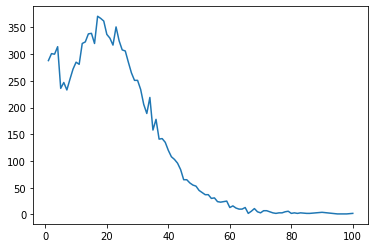

In [ ]:
# I'm ignoring those with 0 because there are way too many
# This type of analysis could be done with minutes, to ignore those that played less than 5-10min in a game, for example
df_adv_stats_clean[df_adv_stats_clean['accurate_pass'] != 0]['accurate_pass'].value_counts().sort_index().plot.line()

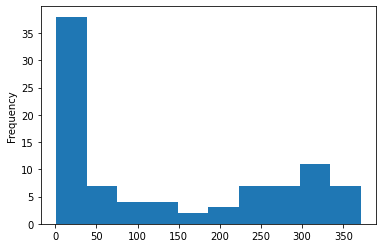

In [ ]:
df_adv_stats_clean['accurate_pass'].value_counts().plot.hist()

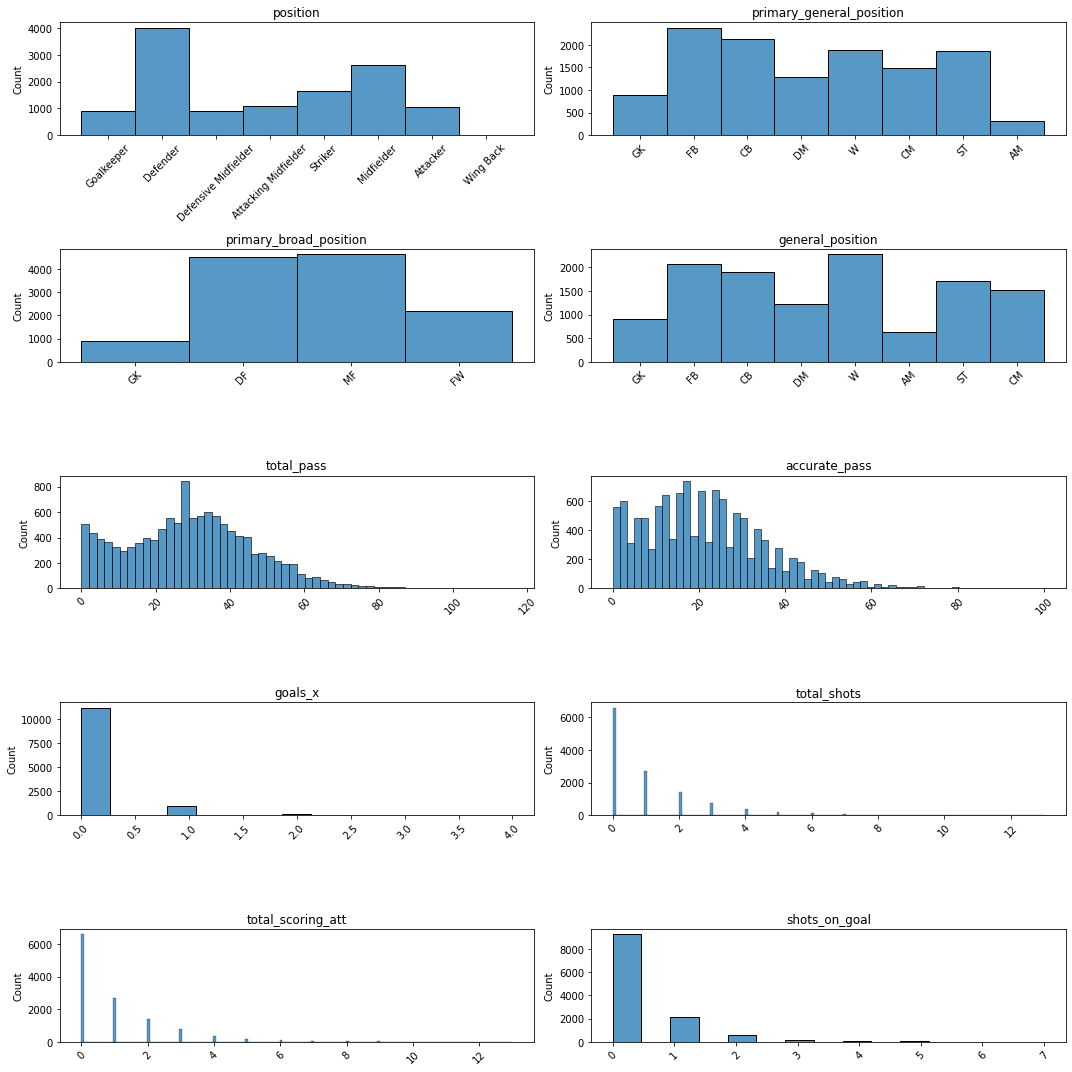

In [ ]:
## Visualize some variables with histplot
variables = ['position', 'primary_general_position', 'primary_broad_position', 'general_position', 'total_pass', 'accurate_pass', 'goals_x', 'total_shots', 'total_scoring_att', 'shots_on_goal']

columns = 2

fig, axes = plt.subplots(math.ceil(len(variables)/columns), columns, figsize=(15,15))

for current_idx, variable in enumerate(variables):
    i = current_idx // columns ## current row
    j = current_idx % columns ## current column
    sns.histplot(df_final2[variable], ax=axes[i][j])
    axes[i][j].set_title(variable)
    axes[i][j].set_xlabel("")
    axes[i][j].tick_params('x', labelrotation=45)  
  
plt.tight_layout()

## Cumulative Frequency

In [ ]:
# define bin size
max_bin = math.ceil(df_adv_stats_clean["accurate_pass"].max()/5 )*5
freq = df_adv_stats_clean["accurate_pass"].value_counts(bins = list(range(0, max_bin+1, 5)), sort=False)

# calculate absolute frequency of accurate passes 
df_freq = pd.DataFrame(freq).rename(columns={'accurate_pass':'abs_freq'})
df_freq["frec_abs_acum"] = df_freq['abs_freq'].cumsum()

# calculate relative frequency
df_freq["freq_rel_%"] = round(100 * df_freq["abs_freq"]/len(df_adv_stats_clean['accurate_pass']),2)
df_freq["freq_rel_%_acum"] = df_freq["freq_rel_%"].cumsum()
df_freq

abs_freq  frec_abs_acum  freq_rel_%  freq_rel_%_acum
(-0.001, 5.0]      1712           1712       13.99            13.99
(5.0, 10.0]        1290           3002       10.54            24.53
(10.0, 15.0]       1601           4603       13.08            37.61
(15.0, 20.0]       1757           6360       14.35            51.96
(20.0, 25.0]       1631           7991       13.33            65.29
(25.0, 30.0]       1358           9349       11.09            76.38
(30.0, 35.0]       1006          10355        8.22            84.60
(35.0, 40.0]        716          11071        5.85            90.45
(40.0, 45.0]        456          11527        3.73            94.18
(45.0, 50.0]        277          11804        2.26            96.44
(50.0, 55.0]        176          11980        1.44            97.88
(55.0, 60.0]        109          12089        0.89            98.77
(60.0, 65.0]         61          12150        0.50            99.27
(65.0, 70.0]         27          12177        0.22            99.49
(70.0, 75.0]         24          12201        0.20            99.69
(75.0, 80.0]         19          12220        0.16            99.85
(80.0, 85.0]         10          12230        0.08            99.93
(85.0, 90.0]          6          12236        0.05            99.98
(90.0, 95.0]          1          12237        0.01            99.99
(95.0, 100.0]         3          12240        0.02           100.01

# Analysis - Bivariable

In [ ]:
# Data Profiling
# profile = ProfileReport(df_players_clean)
# profile

In [ ]:
# Build a dataframe specifically for this part, especially for the heatmap

df_final_analysis = df_final2[
                         ['position', 
                          'primary_broad_position',
                          'sub_position', 
                          'total_pass', 
                          'accurate_pass', 
                          'goals_x', 
                          'total_shots',
                          'total_scoring_att',
                          'shots_on_goal']].copy()

In [ ]:
df_final_analysis[['position', 'total_pass']]

position  total_pass
0                Goalkeeper          41
1                  Defender          42
2                  Defender          64
3                  Defender          67
4                  Defender          32
...                     ...         ...
12235  Attacking Midfielder          20
12236               Striker          26
12237              Defender           6
12238              Attacker          12
12239            Midfielder           8

[12236 rows x 2 columns]

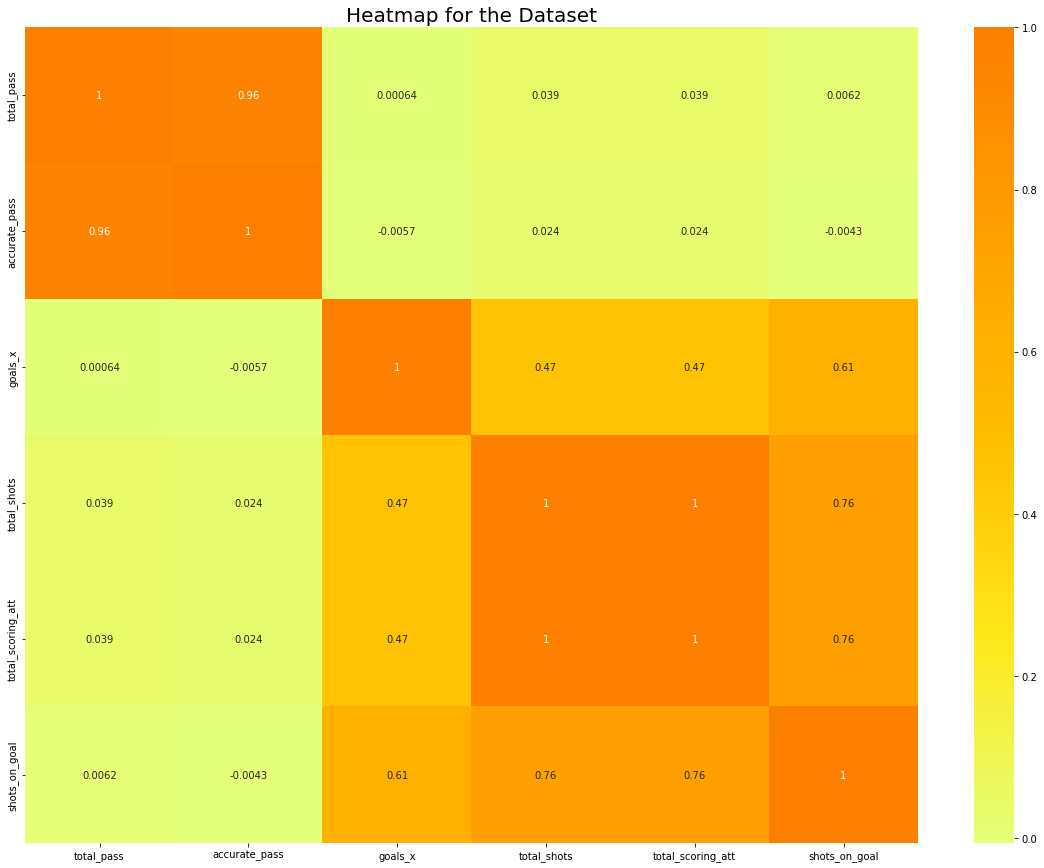

In [ ]:
#Datgframe HeatMap for df_adv_stats_biv
plt.rcParams['figure.figsize'] = (20, 15)

sns.heatmap(df_final_analysis.corr(), annot = True, cmap = 'Wistia')
plt.title('Heatmap for the Dataset', fontsize = 20)

plt.show()

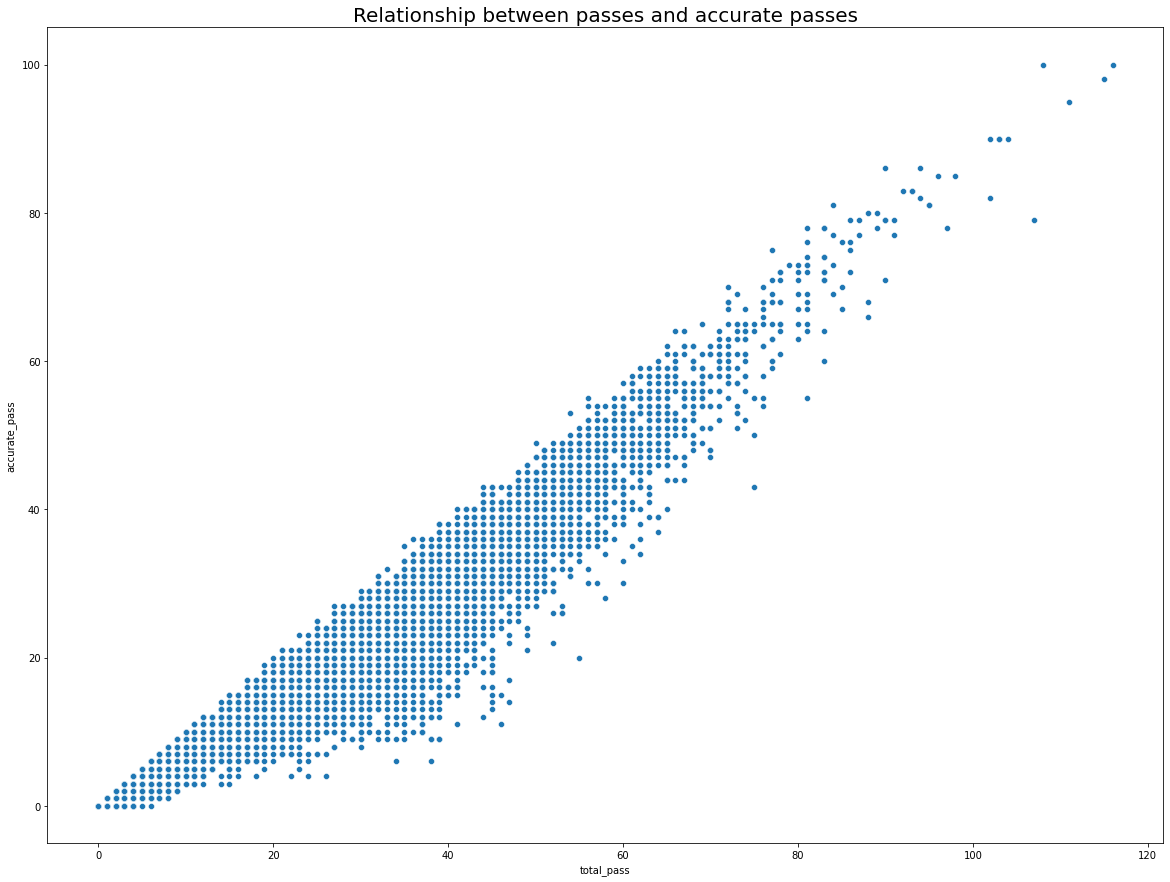

In [ ]:
#Passes vs Passes Complete
sns.scatterplot(
    x = "total_pass", 
    y =  df_final_analysis["accurate_pass"], 
    data = df_final_analysis
  )

plt.title(
    'Relationship between passes and accurate passes', 
    fontsize = 20, 
    fontweight = 30)

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



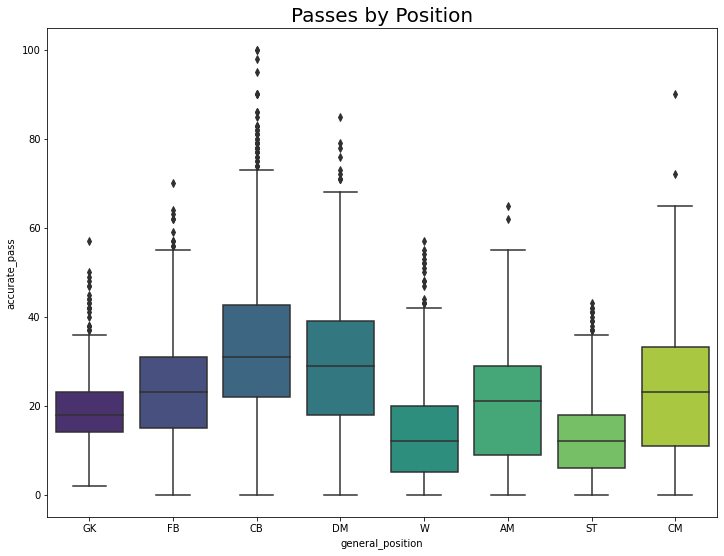

In [ ]:
# Pass Completion vs target
plt.rcParams['figure.figsize'] = (12, 9)

sns.boxplot(
    df_final2['general_position'], 
    df_final2['accurate_pass'], 
    palette = 'viridis'
  )

plt.title(
    'Passes by Position', 
    fontsize = 20
  )

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



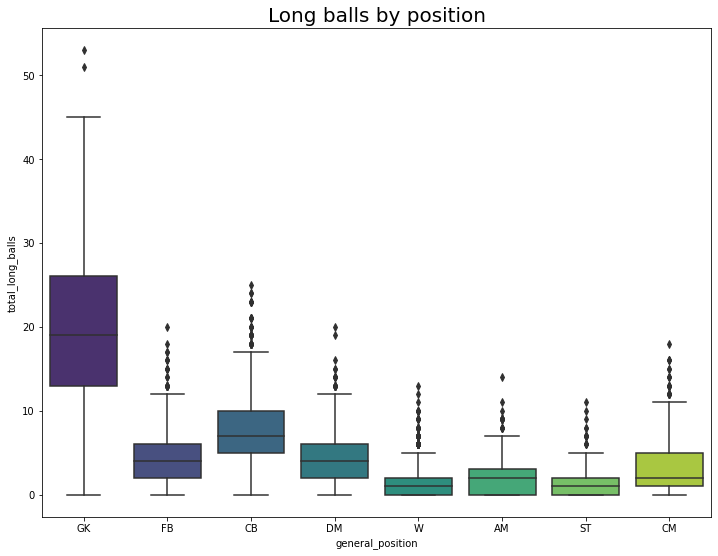

In [ ]:
# Pass Completion vs target
plt.rcParams['figure.figsize'] = (12, 9)

sns.boxplot(
    df_final2['general_position'], 
    df_final2['total_long_balls'], 
    palette = 'viridis'
  )

plt.title(
    'Long balls by position', 
    fontsize = 20
  )

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



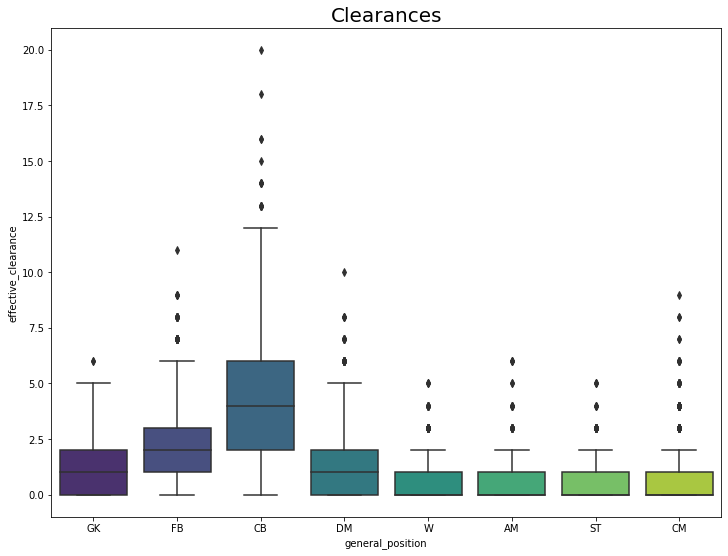

In [ ]:
# Pass Completion vs target
plt.rcParams['figure.figsize'] = (12, 9)

sns.boxplot(
    df_final2['general_position'], 
    df_final2['effective_clearance'], 
    palette = 'viridis'
  )

plt.title(
    'Clearances', 
    fontsize = 20
  )

plt.show()

# Analysis - Multivariable

In [ ]:
df_final_analysis.columns

Index(['position', 'primary_broad_position', 'sub_position', 'total_pass',
       'accurate_pass', 'goals_x', 'total_shots', 'total_scoring_att',
       'shots_on_goal'],
      dtype='object')

In [ ]:
df_passes = df_final2[df_final2['minutes_played'] > 10].copy()
df_passes = df_passes[['position', 
                       'primary_broad_position',
                       'minutes_played',
                       'sub_position', 
                       'total_pass', 
                       'accurate_pass', 
                       'fwd_pass', 
                       'total_final_third_passes',
                       'xgoals', 
                       'total_shots',
                       'total_scoring_att',
                       'shots_on_goal']]

df_passes['pass_%'] = df_passes['accurate_pass']/df_passes['total_pass'] * 100
df_passes['final_third_%_total'] = df_passes['total_final_third_passes']/df_passes['total_pass'] * 100

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



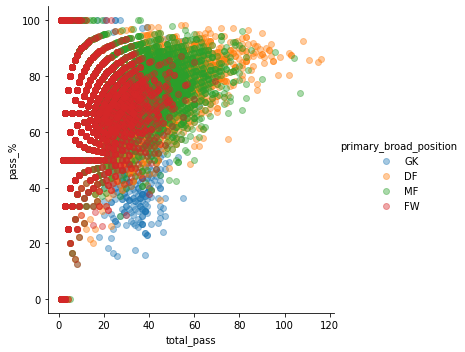

In [ ]:
sns.FacetGrid(
    df_passes, hue = 'primary_broad_position', size = 5).map(
        plt.scatter, 'total_pass', 'pass_%', alpha = 0.4).add_legend();
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



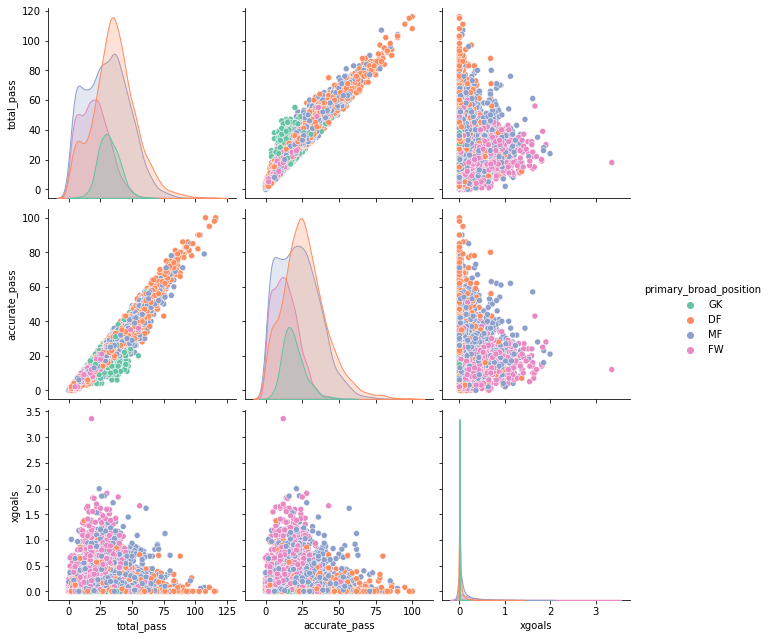

In [ ]:
#Pairplot
df_passes_pairplot = df_final2[df_final2['minutes_played'] > 10].copy()[[ 
      'primary_broad_position',
      'total_pass', 
      'accurate_pass', 
      'xgoals']]

sns.pairplot(df_passes_pairplot, hue = 'primary_broad_position' , size = 3 , palette = 'Set2')

# Classification Algorithm 

The goal of this project is to try and and classify the players into positions, guiding the process with the target that is already available in the dataset, using some stats as features. Because of that the models to try first are those for supervised learning.



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
non_numeric_columns = ['birth_date', 'competition', 'date_time_utc', 'game_id_x', 'game_id_y', 'goal_minutes', 'position', 
                       'shirt_number', 'first_name', 'last_name', 'formation_place', 'formation_place_1', 'full_name', 
                       'game_started', 'height_ft', 'height_in', 'match_name', 'minutes_played', 'nation', 'nationality', 
                       'person_id', 'played_on', 'player_off_id', 'player_on_id', 'player_name', 'player_id_x', 'player_id_y', 
                       'player_id_asa', 'pos', 'position_side', 'primary_broad_position', 'primary_general_position', 'rc', 
                       'red_card', 'season_name', 'second_yellow', 'secondary_broad_position', 'secondary_general_position', 
                       'status', 'sub_position', 'team_id_x', 'team_id_y', 'weight_lb', 'yellow_card', 'yc', 'y_2_c']

In [ ]:
df_final_clean = df_final2.drop(non_numeric_columns, axis=1).copy()

columns_nulls = df_final_clean.isna().any() == True
columns_nulls_true = columns_nulls[columns_nulls == True]
columns_nulls_true.index.values

df_final_clean = df_final_clean.drop(columns_nulls_true.index.values, axis=1)

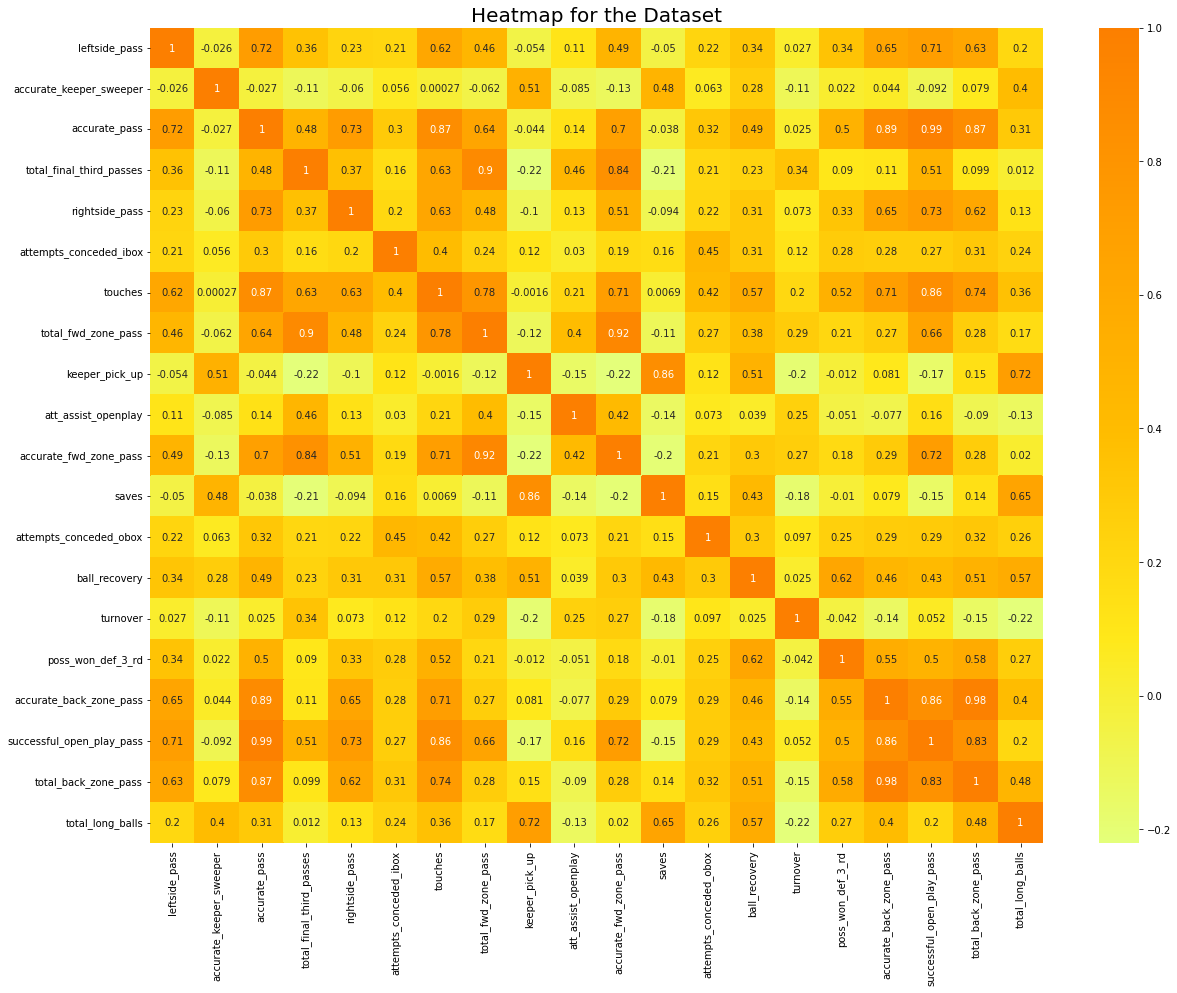

In [ ]:
#Datgframe HeatMap for df_adv_stats_biv
plt.rcParams['figure.figsize'] = (20, 15)

sns.heatmap(df_final_clean.iloc[:, :20].corr(), annot = True, cmap = 'Wistia')
plt.title('Heatmap for the Dataset', fontsize = 20)

plt.show()

In [ ]:
df_final_clean.head(1).T

0
leftside_pass                        6
accurate_keeper_sweeper              1
accurate_pass                       35
total_final_third_passes             2
rightside_pass                       4
...                                ...
xassists                        0.0447
primary_assists_minus_xassists -0.0447
xgoals_plus_xassists            0.0447
points_added                       0.0
xpoints_added                      0.0

[252 rows x 1 columns]

## Train/Test split the data

In [ ]:
# Separate X and Y
# Delete from the dateframe the variable to predict
X = df_final_clean.drop('general_position', axis=1)

# Define the target
y = df_final_clean['general_position'] 

In [ ]:
(df_final_clean.columns)

Index(['leftside_pass', 'accurate_keeper_sweeper', 'accurate_pass',
       'total_final_third_passes', 'rightside_pass', 'attempts_conceded_ibox',
       'touches', 'total_fwd_zone_pass', 'keeper_pick_up',
       'att_assist_openplay',
       ...
       'xgoals', 'xplace', 'goals_minus_xgoals', 'key_passes',
       'primary_assists', 'xassists', 'primary_assists_minus_xassists',
       'xgoals_plus_xassists', 'points_added', 'xpoints_added'],
      dtype='object', length=252)

###Remove columns with low variance

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit(X)
X = X.loc[:, sel.get_support()]

In [ ]:
# Import the library to separate in train y test
from sklearn.model_selection import train_test_split 

# Import the library to evaluate the models
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Use 30% to test and 70% to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import the model
tree_clf = DecisionTreeClassifier(max_depth = 8, random_state = 42) # Create the model

In [ ]:
# Train the model
tree_clf.fit(X_train, y_train)

# Predictions
y_train_pred_DT = tree_clf.predict(X_train) 
y_test_pred_DT = tree_clf.predict(X_test) 

In [ ]:
# Calculate the accuracy in Train
train_accuracy_DT = accuracy_score(y_train, y_train_pred_DT)
# Calculate the accuracy in Test
test_accuracy_DT = accuracy_score(y_test, y_test_pred_DT)

print('% of right guesses for the training set:', train_accuracy_DT)
print('% of right guesses for the evaluation set:', test_accuracy_DT)

# Calculate the F1 Score
f1_test_RF = f1_score(y_test_pred_DT, y_test, average='weighted')
print("F1 score: ", f1_test_RF)

% of right guesses for the training set: 0.6587273788674839
% of right guesses for the evaluation set: 0.5990193407790793
F1 score:  0.6078364453835564


Overall the right guess are low

% of right guess for the training set are around 0.7 <br>
% of right guess for the evaluation set are around 0.6

###First try to graph the tree

Suggested by the expert: Graph the tree to see how the decisions are made

In [ ]:
!pip install graphviz

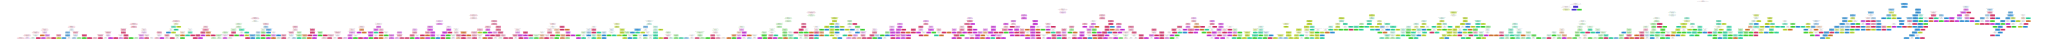

In [ ]:
import graphviz
from sklearn import tree

# DOT data
dot_data = tree.export_graphviz(tree_clf, 
                                out_file = None, 
                                feature_names = list(X.columns.values),
                                class_names = list(y.unique()),
                                filled = True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

### Optimizing hyperparameters

In [ ]:
for i in range(1, 14):
  tree_clf = DecisionTreeClassifier(max_depth = i, random_state = 42) # Create the model
  # Train the model
  scores = cross_val_score(tree_clf, X, y, cv=5)
  tree_clf.fit(X_train, y_train)
  
  # Predictions
  y_train_pred_DT = tree_clf.predict(X_train) 
  y_test_pred_DT = tree_clf.predict(X_test) 

  # Calculate the accuracy in Train
  train_accuracy_DT = accuracy_score(y_train, y_train_pred_DT)
  # Calculate the accuracy in Test
  test_accuracy_DT = accuracy_score(y_test, y_test_pred_DT)
  print('max_depth:', i)
  print('% of right guesses for the training set:', train_accuracy_DT)
  print('% of right guesses for the evaluation set:', test_accuracy_DT)
  print("%0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

  # Calculate the F1 Score
  f1_test_RF = f1_score(y_test_pred_DT, y_test, average='weighted')
  print("F1 score: ", f1_test_RF)
  print('\n\n')

max_depth: 1
% of right guesses for the training set: 0.3116170461179218
% of right guesses for the evaluation set: 0.31871424679923727
0.3137 accuracy with a standard deviation of 0.0036
F1 score:  0.429773896812588



max_depth: 2
% of right guesses for the training set: 0.3843549328663164
% of right guesses for the evaluation set: 0.3928084990465813
0.3861 accuracy with a standard deviation of 0.0038
F1 score:  0.49857310502283775



max_depth: 3
% of right guesses for the training set: 0.5089316987740805
% of right guesses for the evaluation set: 0.5047670934350313
0.5065 accuracy with a standard deviation of 0.0078
F1 score:  0.6061086725325093



max_depth: 4
% of right guesses for the training set: 0.5523642732049037
% of right guesses for the evaluation set: 0.5543448651593571
0.5439 accuracy with a standard deviation of 0.0107
F1 score:  0.5889645944893974



max_depth: 5
% of right guesses for the training set: 0.5808523058960887
% of right guesses for the evaluation set: 0.5

### Optimizing hyperparameters - GridSearchCV

**StratifiedKFold**

In [ ]:
tree_clf_hyper = DecisionTreeClassifier()

#StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

skf_tree = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
SKF_train, SKF_test = list(skf_tree.split(X, y))[0]

In [ ]:
X_train_SKF = X.iloc[SKF_train]
X_test_SKF = X.iloc[SKF_test]
y_train_SKF = y.iloc[SKF_train]
y_test_SKF = y.iloc[SKF_test]

In [ ]:
par_alpha = list(np.arange(0, 5, step = 1))
par_depth = list(np.arange(1, 20, step = 1))

cv_tree_SKF = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)
tunner_df = GridSearchCV(estimator = tree_clf_hyper, param_grid={'ccp_alpha': par_alpha, 'max_depth': par_depth}, cv = cv_tree_SKF, n_jobs = -1)
_=tunner_df.fit(X_train_SKF, y_train_SKF)

In [ ]:
print('Train score StratifiedKFold: ' + str(tunner_df.score(X_train_SKF, y_train_SKF)))
print('Test score StratifiedKFold: ' + str(tunner_df.score(X_test_SKF, y_test_SKF)))

Train score StratifiedKFold: 0.6995300367797302
Test score StratifiedKFold: 0.5968137254901961


In [ ]:
print("Best parameter using StratifiedKFold: "+str(tunner_df.best_params_))
print("Best Score using StratifiedKFold: "+str(tunner_df.best_score_)+'\n')

Best parameter using StratifiedKFold: {'ccp_alpha': 0, 'max_depth': 10}
Best Score using StratifiedKFold: 0.6034918782422701



**KFold**

In [ ]:
#KFold
from sklearn.model_selection import KFold

tree_KFold_aug = KFold(n_splits=5, random_state=0, shuffle=True)
tree_train_KF, tree_test_KF = list(tree_KFold_aug.split(X))[0]
tree_X_train_KF = X.iloc[tree_train_KF]
tree_X_test_KF = X.iloc[tree_test_KF]
tree_y_train_KF = y.iloc[tree_train_KF]
tree_y_test_KF = y.iloc[tree_test_KF]

In [ ]:
cv_KF = KFold(n_splits = 5, random_state = 0, shuffle = True)
tree_tunner_KF = GridSearchCV(
    estimator = tree_clf_hyper, 
    param_grid = {'ccp_alpha': par_alpha, 'max_depth': par_depth}, 
    cv = cv_KF, 
    n_jobs = -1)
_=tree_tunner_KF.fit(tree_X_train_KF, tree_y_train_KF)

In [ ]:
#Metrics
print('Train score KFold: ' + str(tree_tunner_KF.score(tree_X_train_KF, tree_y_train_KF)))
print('Test score KFold: ' + str(tree_tunner_KF.score(tree_X_test_KF, tree_y_test_KF)))

Train score KFold: 0.6428279525950144
Test score KFold: 0.6115196078431373


In [ ]:
print("Best parameters using KFold: "+str(tree_tunner_KF.best_params_))
print("Best Score using KFold: "+str(tree_tunner_KF.best_score_)+'\n')

Best parameters using KFold: {'ccp_alpha': 0, 'max_depth': 8}
Best Score using KFold: 0.5959335623985138



In [ ]:
# Predicting 
tree_prediction_KF = tree_tunner_KF.predict(tree_X_test_KF)

In [ ]:
#Accuracy
print('Accuracy Score for the prediction:', accuracy_score(tree_y_test_KF, tree_prediction_KF))

### Optimizing hyperparameters - RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

In [ ]:
tunner_tree_rndCV = RandomizedSearchCV(
    tree_clf_hyper, 
    param_distributions = {'ccp_alpha': par_alpha, 'max_depth': par_depth},
    n_iter = 100, 
    random_state = 0, 
    cv = 5
  )

In [ ]:
_=tunner_tree_rndCV.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning:

The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.



In [ ]:
print("Best parameters with RandomizedSearchCV: " + str(tunner_tree_rndCV.best_params_))
print("Best score with RandomizedSearchCV: " + str(tunner_tree_rndCV.best_score_)+'\n')

Best parameters with RandomizedSearchCV: {'max_depth': 7, 'ccp_alpha': 0.0}
Best score with RandomizedSearchCV: 0.5997664915353182



In [ ]:
# Predicting 
prediction_tree_rdnCV = tunner_tree_rndCV.predict(X_test)

In [ ]:
#Accuracy
print('Accuracy Score for the prediction:', accuracy_score(y_test, prediction_tree_rdnCV))

Accuracy Score for the prediction: 0.5965676927267775


## Support Vector Machines

In [ ]:
from sklearn.svm import SVC

# SVM model 
SVM_model = SVC(C = 1, kernel = 'linear', random_state=123)
SVM_model.fit(X_train, y_train)

# Predictions
y_train_pred_SVM = SVM_model.predict(X_train)
y_test_pred_SVM = SVM_model.predict(X_test)

In [ ]:
# Calculate train accuracy
train_accuracy_SVM = accuracy_score(y_train, y_train_pred_SVM)
# Calculate test accuracy
test_accuracy_SVM = accuracy_score(y_test, y_test_pred_SVM)

print('% of right guesses for the training set: ', train_accuracy_SVM)
print('% of right guesses for the evaluation set: ', test_accuracy_SVM)

# Calculate the F1 Score
f1_test_RF = f1_score(y_test_pred_SVM, y_test, average='weighted')
print("F1 score: ", f1_test_RF)

% of right guesses for the training set:  0.748861646234676
% of right guesses for the evaluation set:  0.6706619449741215
F1 score:  0.6728769393473727


The SVM model is better than the decision tree, specially if comparing the accuracy of the evaluation set, with 0.07 points of difference.

### Optimizing hyperparameters - GridSearchCV

**StratifiedKFold**

In [ ]:
SVC_clf_hyper =  SVC()

#StratifiedKFold
skf_SVC = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True)
SVC_train_SKF, SVC_test_SKF = list(skf_SVC.split(X, y))[0]

SVC_X_train_SKF = X.iloc[SVC_train_SKF]
SVC_X_test_SKF = X.iloc[SVC_test_SKF]
SVC_y_train_SKF = y.iloc[SVC_train_SKF]
SVC_y_test_SKF = y.iloc[SVC_test_SKF]

SVC_par_kernel = ['linear', 'rbf', 'poly']

In [ ]:
SVC_cv_SKF = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)
SVC_tunner_SKF = GridSearchCV(
    estimator = SVC_clf_hyper, 
    param_grid = {'kernel': SVC_par_kernel}, 
    cv = SVC_cv_SKF, 
    n_jobs = -1)
_=SVC_tunner_SKF.fit(SVC_X_train_SKF, SVC_y_train_SKF)

In [ ]:
print('Train score StratifiedKFold: ' + str(SVC_tunner_SKF.score(SVC_X_train_SKF, SVC_y_train_SKF)))
print('Test score StratifiedKFold: ' + str(SVC_tunner_SKF.score(SVC_X_test_SKF, SVC_y_test_SKF)))

Train score StratifiedKFold: 0.7387617490805067
Test score StratifiedKFold: 0.6899509803921569


In [ ]:
print("Best parameter using StratifiedKFold: "+str(SVC_tunner_SKF.best_params_))
print("Best Score using StratifiedKFold: "+str(SVC_tunner_SKF.best_score_)+'\n')

Best parameter using StratifiedKFold: {'C': 1, 'kernel': 'linear'}
Best Score using StratifiedKFold: 0.6722509960055388



**KFold**

In [ ]:
#KFold
from sklearn.model_selection import KFold

KFold_aug = KFold(n_splits = 5, random_state = 0, shuffle = True)
SVC_train_KF, SVC_test_KF = list(KFold_aug.split(X))[0]
SVC_X_train_KF = X.iloc[SVC_train_KF]
SVC_X_test_KF = X.iloc[SVC_test_KF]
SVC_y_train_KF = y.iloc[SVC_train_KF]
SVC_y_test_KF = y.iloc[SVC_test_KF]

In [ ]:
SVC_cv_KF = KFold(n_splits = 5, random_state = 0, shuffle = True)
SVC_tunner_KF = GridSearchCV(
    estimator = SVC_clf_hyper, 
    param_grid = {'kernel': SVC_par_kernel}, 
    cv = SVC_cv_KF, 
    n_jobs = -1)
_=SVC_tunner_KF.fit(SVC_X_train_KF, SVC_y_train_KF)

In [ ]:
#Metrics
print('Train score KFold: ' + str(SVC_tunner_KF.score(SVC_X_train_KF, SVC_y_train_KF)))
print('Test score KFold: ' + str(SVC_tunner_KF.score(SVC_X_test_KF, SVC_y_test_KF)))

Train score KFold: 0.7392725786677564
Test score KFold: 0.6891339869281046


In [ ]:
print("Best parameters using KFold: "+str(SVC_tunner_KF.best_params_))
print("Best Score using KFold: "+str(SVC_tunner_KF.best_score_)+'\n')

Best parameters using KFold: {'kernel': 'linear'}
Best Score using KFold: 0.6670411289089271



### Optimizing hyperparameters - RandomizedSearchCV

In [ ]:
SVC_tunner_rndCV = RandomizedSearchCV(
    SVC_clf_hyper, 
    param_distributions = {'kernel': SVC_par_kernel},
    n_iter = 3, 
    random_state = 0, 
    cv = 5
  )

In [ ]:
_=SVC_tunner_rndCV.fit(X_train, y_train)

In [ ]:
print("Best parameters with RandomizedSearchCV: " + str(SVC_tunner_rndCV.best_params_))
print("Best score with RandomizedSearchCV: " + str(SVC_tunner_rndCV.best_score_)+'\n')

Best parameters with RandomizedSearchCV: {'kernel': 'linear'}
Best score with RandomizedSearchCV: 0.675072971395213



In [ ]:
# Predicting 
SVC_prediction_rdnCV = SVC_tunner_rndCV.predict(X_test)

In [ ]:
#Accuracy
print('Accuracy Score for the prediction:', accuracy_score(y_test, SVC_prediction_rdnCV))

Accuracy Score for the prediction: 0.6706619449741215


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_clf = RandomForestClassifier(n_estimators = 50, random_state = 42, n_jobs = -1)
RF_clf.fit(X_train, y_train)

# Predictions
RF_y_train_pred = RF_clf.predict(X_train)
RF_y_test_pred = RF_clf.predict(X_test)

In [ ]:
# Calculate train accuracy
RF_train_accuracy = accuracy_score(y_train, RF_y_train_pred)
# Calculate test accuracy
RF_test_accuracy = accuracy_score(y_test, RF_y_test_pred)

print('% of right guesses for the training set:', RF_train_accuracy)
print('% of right guesses for the evaluation set:', RF_test_accuracy)

# Calculate the F1 Score
RF_f1_test = f1_score(RF_y_test_pred, y_test, average = 'weighted')
print("F1 score: ", RF_f1_test)

% of right guesses for the training set: 0.9976649153531816
% of right guesses for the evaluation set: 0.6480523018251158
F1 score:  0.660240362895623


The Random Forest model performs WAY better than the other two models with the training set, getting an accuracy of 0.997. But once tested, the metric is a little bit worse than the one for SVM, by 0.02 points. F1 Score is also worse, by 0.01 point.

Although there is a difference, one thing to note is that the Random Forest model takes less time than the SVM model, by a lot. Of course, this applies for the hyper parameters used here (n_estimators=50, random_state=42, n_jobs=-1), as other values would cause the model to take longer.

### Importance of the features

In [ ]:
RF_clf.feature_importances_

array([1.32228706e-02, 1.41532000e-02, 1.44429871e-02, 1.17544741e-02,
       1.00863133e-02, 1.32207874e-02, 1.30152108e-02, 1.47737658e-02,
       3.64025528e-03, 1.15260450e-02, 3.96932452e-03, 9.47607829e-03,
       9.97666869e-03, 6.66810161e-03, 9.86426503e-03, 2.28223573e-02,
       1.34404854e-02, 2.62928398e-02, 1.33058724e-02, 4.45530010e-03,
       2.18959955e-02, 1.45599188e-02, 1.49716863e-02, 1.22743875e-02,
       2.23332690e-02, 3.05349136e-03, 1.91381740e-02, 1.41377970e-02,
       6.93256105e-03, 2.05235644e-03, 1.23109293e-02, 8.29717058e-03,
       1.06382892e-02, 2.21585315e-03, 6.49356891e-03, 1.16453774e-02,
       1.05973846e-02, 1.46425133e-02, 1.26802506e-02, 3.73323211e-03,
       1.49199121e-02, 1.28894076e-02, 1.72518308e-03, 4.00544638e-03,
       6.95113995e-03, 1.78771429e-03, 3.65157174e-03, 5.44322826e-03,
       7.40879219e-03, 3.03853863e-03, 4.37899508e-03, 5.70317741e-02,
       3.47154999e-03, 8.24679610e-03, 7.86710521e-03, 1.34375146e-02,
      

In [ ]:
# It is possible to extract the features that are more important for the correct classification of the data
feature_importances = {name: score for name, score in zip(list(df_final_clean), RF_clf.feature_importances_)}

In [ ]:
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances_sorted.head(20)

total_throws                     0.048580
accurate_throws                  0.039109
fwd_pass                         0.023055
total_back_zone_pass             0.022721
accurate_back_zone_pass          0.022272
long_pass_own_to_opp             0.020451
successful_final_third_passes    0.016057
successful_open_play_pass        0.015594
total_long_balls                 0.015357
effective_clearance              0.015131
total_clearance                  0.014963
backward_pass                    0.013615
mins_played                      0.012837
saves                            0.012635
total_fwd_zone_pass              0.012521
poss_lost_all                    0.012433
total_final_third_passes         0.012406
leftside_pass                    0.012192
accurate_pass                    0.012144
touches                          0.012012
dtype: float64

It would be possible to generate the Random Forest model with only these features, as they seem to be the most important and have the most impact in the model.

Part of the cleaning of the data could be dropping some of these columns that are highly related, like "total_throws" affects directly the amount of "accurate_throws"

### Optimizing hyperparameters

In [ ]:
for i in range(10,60):
  clf_rnd = RandomForestClassifier(n_estimators = i, random_state = 42, n_jobs = -1)
  scores = cross_val_score(clf_rnd, X, y, cv = 5)
  print("%0.6f accuracy with a standard deviation of %0.6f" % (scores.mean(), scores.std()))
  clf_rnd.fit(X_train, y_train)

  # Predictions
  y_train_pred_RF = clf_rnd.predict(X_train)
  y_test_pred_RF = clf_rnd.predict(X_test)
  
  # Calculate train accuracy
  train_accuracy_RF = accuracy_score(y_train, y_train_pred_RF)
  # Calculate test accuracy
  test_accuracy_RF = accuracy_score(y_test, y_test_pred_RF)
  print('n_estimators:', i)
  print('% of right guesses for the training set:', train_accuracy_RF)
  print('% of right guesses for the evaluation set:', test_accuracy_RF)

  # Calculate the F1 Score
  f1_test_RF = f1_score(y_test_pred_RF, y_test, average='weighted')
  print("F1 score: ", f1_test_RF)

0.613521 accuracy with a standard deviation of 0.022809
n_estimators: 10
% of right guesses for the training set: 0.989492119089317
% of right guesses for the evaluation set: 0.6009261781530918
F1 score:  0.6069205998271109
0.616953 accuracy with a standard deviation of 0.021455
n_estimators: 11
% of right guesses for the training set: 0.9912434325744308
% of right guesses for the evaluation set: 0.5995641514573685
F1 score:  0.6052790900809156
0.618016 accuracy with a standard deviation of 0.023754
n_estimators: 12
% of right guesses for the training set: 0.992527729130181
% of right guesses for the evaluation set: 0.6025606101879597
F1 score:  0.6091420972758429
0.622837 accuracy with a standard deviation of 0.021237
n_estimators: 13
% of right guesses for the training set: 0.993928779918272
% of right guesses for the evaluation set: 0.6093707436665758
F1 score:  0.6166573611648791
0.624390 accuracy with a standard deviation of 0.022892
n_estimators: 14
% of right guesses for the tra

### Optimizing hyperparameters - GridSearchCV

**GridSearchCV - StratifiedKFold**

In [ ]:
RF_clf_GCV = RandomForestClassifier()

#StratifiedKFold
skf_rnd = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True)
RF_train_SKF, RF_test_SKF = list(skf_rnd.split(X, y))[0]

RF_X_train_SKF = X.iloc[RF_train_SKF]
RF_X_test_SKF = X.iloc[RF_test_SKF]
RF_y_train_SKF = y.iloc[RF_train_SKF]
RF_y_test_SKF = y.iloc[RF_test_SKF]

In [ ]:
RF_par_estimators = list(np.arange(1, 50, step = 5))
RF_par_state = list(np.arange(0, 48, step = 8))

RF_GCV_SKF = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)
RF_tunner_SKF = GridSearchCV(
    estimator = RF_clf_GCV, 
    param_grid = {'n_estimators': RF_par_estimators, 'random_state': RF_par_state}, 
    cv = RF_GCV_SKF, 
    n_jobs = -1
  )

_=RF_tunner_SKF.fit(RF_X_train_SKF, RF_y_train_SKF)

In [ ]:
print('Train score StratifiedKFold: ' + str(RF_tunner_SKF.score(RF_X_train_SKF, RF_y_train_SKF)))
print('Test score StratifiedKFold: ' + str(RF_tunner_SKF.score(RF_X_test_SKF, RF_y_test_SKF)))

Train score StratifiedKFold: 0.9979566816510013
Test score StratifiedKFold: 0.6441993464052288


In [ ]:
print("Best parameter using StratifiedKFold: "+str(RF_tunner_SKF.best_params_))
print("Best Score using StratifiedKFold: "+str(RF_tunner_SKF.best_score_)+'\n')

Best parameter using StratifiedKFold: {'n_estimators': 46, 'random_state': 32}
Best Score using StratifiedKFold: 0.6588681159745562



**GridSearchCV - KFold**

In [ ]:
#KFold
KFold_rnd_aug= KFold(n_splits = 5, random_state = 0, shuffle = True)
RF_train_KF, RF_test_KF = list(KFold_rnd_aug.split(X))[0]
RF_X_train_KF = X.iloc[RF_train_KF]
RF_X_test_KF = X.iloc[RF_test_KF]
RF_y_train_KF = y.iloc[RF_train_KF]
RF_y_test_KF = y.iloc[RF_test_KF]

In [ ]:
RF_GCV_KF = KFold(n_splits = 5, random_state = 0, shuffle = True)
tunner_rnd_KF = GridSearchCV(
    estimator = RF_clf_GCV, 
    param_grid = {'n_estimators': RF_par_estimators, 'random_state': RF_par_state}, 
    cv = RF_GCV_KF, 
    n_jobs = -1)

_=tunner_rnd_KF.fit(RF_X_train_KF, RF_y_train_KF)

In [ ]:
#Metrics
print('Train score KFold: ' + str(tunner_rnd_KF.score(RF_X_train_KF, RF_y_train_KF)))
print('Test score KFold: ' + str(tunner_rnd_KF.score(RF_X_test_KF, RF_y_test_KF)))

Train score KFold: 0.9978545157335513
Test score KFold: 0.6683006535947712


In [ ]:
print("Best parameters using KFold: "+str(tunner_rnd_KF.best_params_))
print("Best Score using KFold: "+str(tunner_rnd_KF.best_score_)+'\n')

Best parameters using KFold: {'n_estimators': 36, 'random_state': 0}
Best Score using KFold: 0.6494677444526158



### Optimizing hyperparameter - RandomizedSearchCV

In [ ]:
clf_rnd = RandomForestClassifier()

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
RF_par_estimators = list(np.arange(1, 50, step = 5))
RF_par_state = list(np.arange(0, 48, step = 8))

In [ ]:
random_grid

{'bootstrap': [True, False],
 'max_depth': [3, 4, 6, 8, 9, 11, 13, 14, 16, 18, 20, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000]}

In [ ]:
RF_tunner_rndCV = RandomizedSearchCV(
    clf_rnd, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 3, 
    verbose=2, 
    random_state=42, 
    n_jobs = -1)

In [ ]:
RF_tunner_rndCV.fit(X_train, y_train)

In [ ]:
print("Best parameters with RandomizedSearchCV: " + str(RF_tunner_rndCV.best_params_))
print("Best score with RandomizedSearchCV: " + str(RF_tunner_rndCV.best_score_)+'\n')

In [ ]:
print("Best parameters with RandomizedSearchCV: " + str(RF_tunner_rndCV.best_params_))
print("Best score with RandomizedSearchCV: " + str(RF_tunner_rndCV.best_score_)+'\n')

Best parameters with RandomizedSearchCV: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}
Best score with RandomizedSearchCV: 0.6762405137186223



In [ ]:
# Predicting 
RF_prediction_rdnCV = RF_tunner_rndCV.predict(X_test)

In [ ]:
#Accuracy
print('Accuracy Score for the prediction:', accuracy_score(y_test, RF_prediction_rdnCV))

Accuracy Score for the prediction: 0.6469626804685372


## Neural network

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
clf = MLPClassifier(max_iter=100)

In [ ]:
random_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'max_iter': [100, 200, 300],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [ ]:
nnw_cv = RandomizedSearchCV(
    clf, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 3, 
    verbose=3, 
    random_state=42, 
    n_jobs = -1)

In [ ]:
nnw_cv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
# Predictions
y_train_pred = nnw_cv.predict(X_train)
y_test_pred = nnw_cv.predict(X_test)

In [ ]:
# Calculate train accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% of right guesses for the training set: ', train_accuracy)
print('% of right guesses for the evaluation set: ', test_accuracy)

# Calculate the F1 Score
f1_test_RF = f1_score(y_test_pred, y_test, average='weighted')
print("F1 score: ", f1_test_RF)

% of right guesses for the training set:  0.9510799766491536
% of right guesses for the evaluation set:  0.6273494960501226
F1 score:  0.6263647269307572


In [ ]:
print("Best parameters with RandomizedSearchCV: " + str(nnw_cv.best_params_))
print("Best score with RandomizedSearchCV: " + str(nnw_cv.best_score_)+'\n')

Best parameters with RandomizedSearchCV: {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 100, 50), 'alpha': 0.05, 'activation': 'relu'}
Best score with RandomizedSearchCV: 0.6969060128429656



## Clustering K-Means

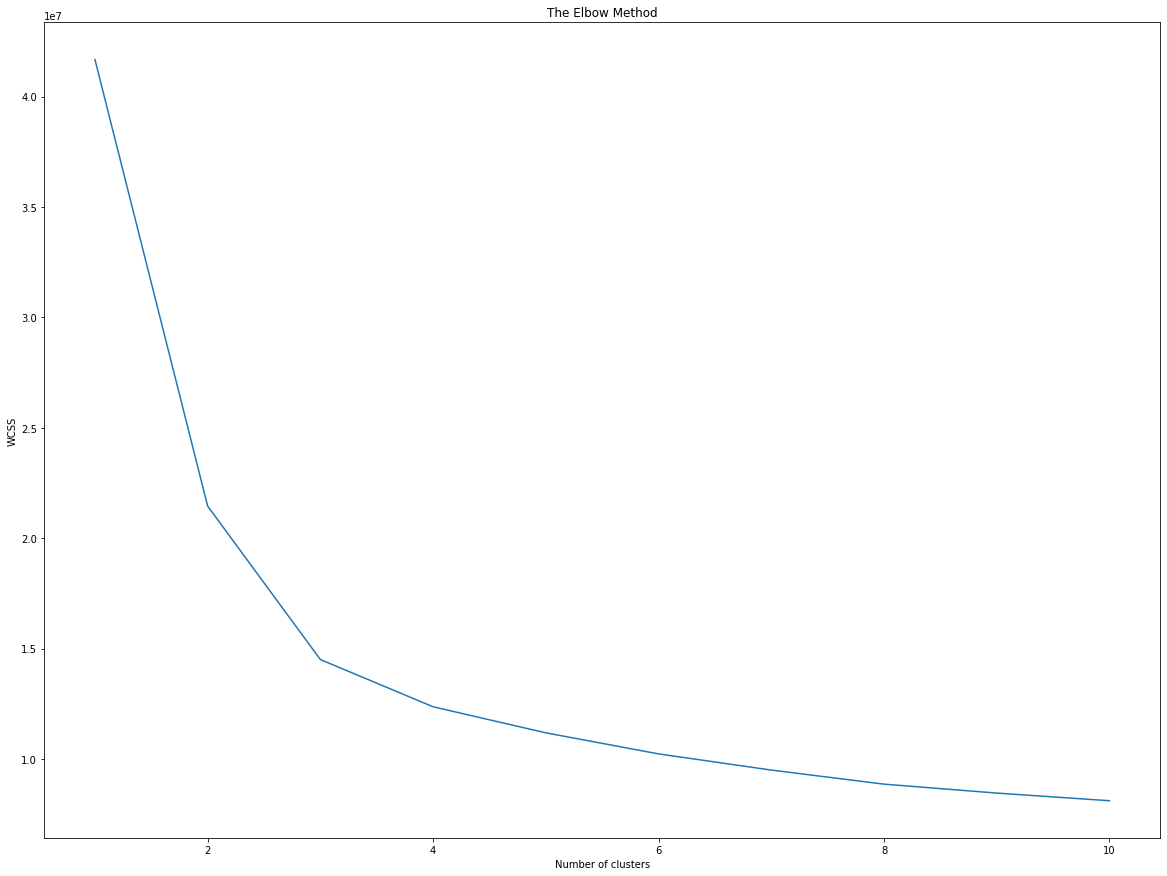

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Graphic with the sum of the distances
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# Creating the k-Means for the 4 groups found
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42) 
#k-means++ accelerates the convergence in relation with random
y_kmeans = kmeans.fit_predict(X)

In [ ]:
kmeans.cluster_centers_

array([[8.15799568e+00, 2.70918245e-02, 2.77597698e+01, ...,
        1.76480269e-01, 4.75829298e-02, 5.75920914e-02],
       [4.75224327e+00, 9.32203390e-02, 1.54436690e+01, ...,
        1.89580409e-01, 5.41385095e-02, 7.43538190e-02],
       [1.53803705e+00, 3.94166338e-04, 4.81119432e+00, ...,
        7.07050847e-02, 1.85093023e-02, 2.81092658e-02],
       [1.39663588e+01, 3.29815303e-03, 4.73674142e+01, ...,
        1.27028100e-01, 3.75261873e-02, 3.88731530e-02]])

To be able to graph it, the features are reduced to 2 with PCA

In [ ]:
from sklearn.decomposition import PCA

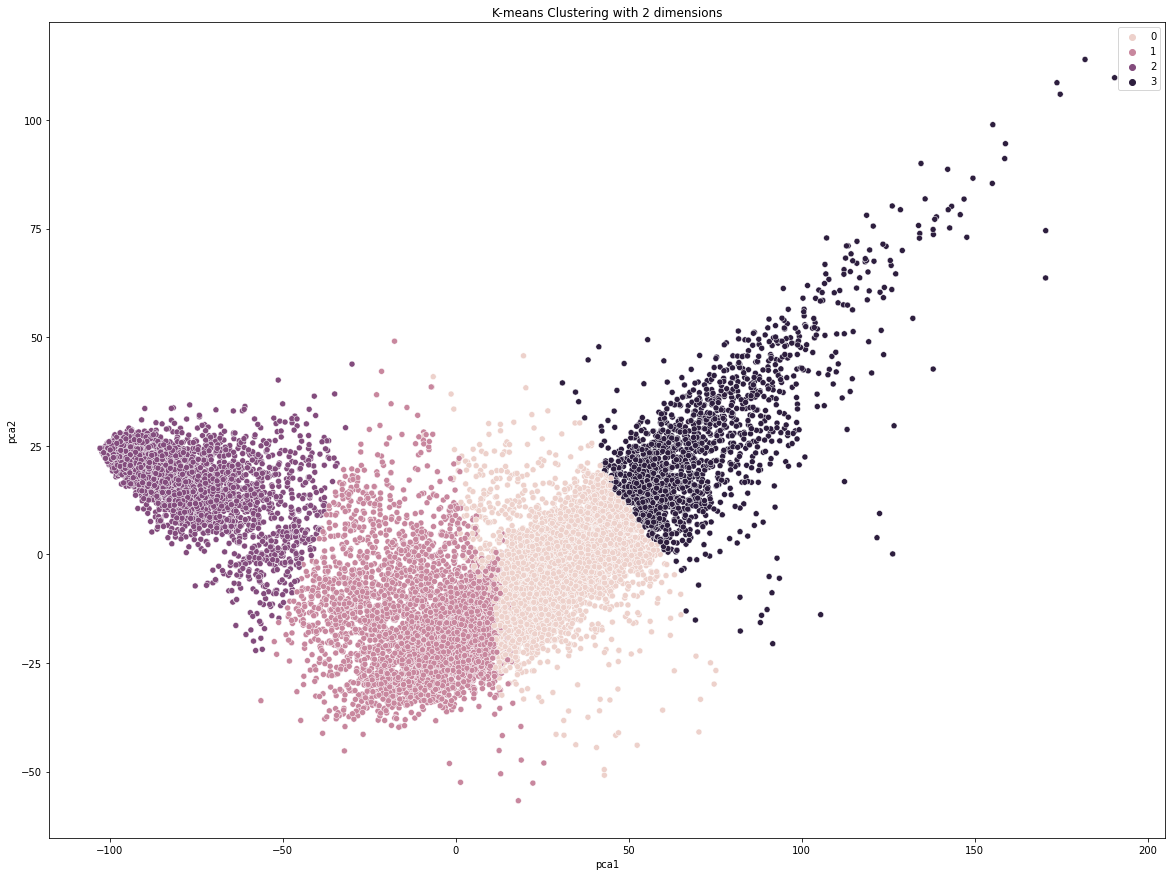

In [ ]:
# Graphic visualization of the clusters

### Run PCA on the data and reduce the dimensions in pca_num_components dimensions

pca_num_components = 2

reduced_data = PCA(n_components = pca_num_components).fit_transform(X)
results = pd.DataFrame(reduced_data, columns = ['pca1','pca2'])

sns.scatterplot(x = "pca1", y = "pca2", hue = y_kmeans, data = results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

As discussed with the expert (the professor) K-Means is not really an option because it is unsupervised, and there's no way to guide it to get the expected groups.

> Try this one first LVQ: This one is not implemented on Python

> Maybe a K-Means that receives categories: After some investigation is not a process easily accessible, it would need a deeper investigation.

TCNE - Check if it is in python



## xGBoost

In [ ]:
import xgboost as xgb

In [ ]:
clf_xgb = xgb.XGBClassifier(
    objective = 'multi:softmax', 
    num_class = 8,
    n_estimators = 75, 
    seed = 15)

In [ ]:
clf_xgb.fit(X_train, y_train)

XGBClassifier(n_estimators=75, num_class=8, objective='multi:softprob', seed=15)

In [ ]:
xgb_y_train_pred = clf_xgb.predict(X_train)
xgb_y_test_pred = clf_xgb.predict(X_test)

In [ ]:
# Calculate the accuracy in Train
xgb_train_accuracy = accuracy_score(y_train, xgb_y_train_pred)

# Calculate the accuracy in Test
xgb_test_accuracy = accuracy_score(y_test, xgb_y_test_pred)

print('% de aciertos sobre el set de entrenamiento:', xgb_train_accuracy)
print('% de aciertos sobre el set de evaluación:', xgb_test_accuracy)

# Calculate the F1 Score
print("F1 score: ", f1_score(xgb_y_test_pred, y_test, average = 'weighted'))

% de aciertos sobre el set de entrenamiento: 0.7223584354932866
% de aciertos sobre el set de evaluación: 0.6603105420866249
F1 score:  0.6746860798178325


### Optimizing hyperparameters - RandomizedSearchCV

In [ ]:
#https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

In [ ]:
clf = xgb.XGBClassifier(
    objective = 'multi:softmax', 
    num_class = 8,
    n_estimators = 75, 
    seed = 15)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
random_grid = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [ ]:
random_grid

{'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
 'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight': [1, 3, 5, 7]}

In [ ]:
XGB_tunner_CV = RandomizedSearchCV(
    clf, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 3, 
    verbose=3, 
    random_state=42, 
    n_jobs = -1)

In [ ]:
XGB_tunner_CV.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(n_estimators=75, num_class=8,
                                           objective='multi:softmax', seed=15),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   random_state=42, verbose=3)

In [ ]:
print("Best parameters with RandomizedSearchCV: " + str(XGB_tunner_CV.best_params_))
print("Best score with RandomizedSearchCV: " + str(XGB_tunner_CV.best_score_)+'\n')

Best parameters with RandomizedSearchCV: {'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best score with RandomizedSearchCV: 0.6765907764156451



In [ ]:
pd.DataFrame(XGB_tunner_CV.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      16.109694      2.823179         0.126813        0.000550   
1      23.452585      2.232597         0.172381        0.023692   

  param_min_child_weight param_max_depth param_learning_rate param_gamma  \
0                      5               4                 0.2         0.1   
1                      7               8                 0.1         0.3   

  param_colsample_bytree                                             params  \
0                    0.7  {'min_child_weight': 5, 'max_depth': 4, 'learn...   
1                    0.7  {'min_child_weight': 7, 'max_depth': 8, 'learn...   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.672504           0.671454           0.685814         0.676591   
1           0.669352           0.675657           0.682662         0.675890   

   std_test_score  rank_test_score  
0        0.006536                1  
1        0.005436                2

# Ensamble

## Bagging method

In [ ]:
ensemble_models = []
all_positions = y.unique()

In [ ]:
df_train, df_test = train_test_split(df_final_clean, test_size = 0.30, random_state = 42)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
for position in all_positions:
  true_datapoints = df_train[df_train['general_position'] == position]
  false_datapoints = df_train[df_train['general_position'] != position].sample(len(true_datapoints))

  aux_df = true_datapoints.append(false_datapoints, ignore_index=True)
  X_aux = aux_df.drop(columns='general_position')
  y_aux = (aux_df['general_position']==position).astype(int)

  X_train, X_test, y_train, y_test = train_test_split(X_aux, y_aux, test_size = 0.30, random_state = 42)

  rf = RandomForestClassifier()
  rf.fit(X_train, y_train)

  # Predictions
  y_train_pred_RF = rf.predict(X_train)
  y_test_pred_RF = rf.predict(X_test)

  # Calculate train accuracy
  train_accuracy_RF = accuracy_score(y_train, y_train_pred_RF)
  # Calculate test accuracy
  test_accuracy_RF = accuracy_score(y_test, y_test_pred_RF)
  print('prediction for position: ', position)
  print('% of right guesses for the training set:', train_accuracy_RF)
  print('% of right guesses for the evaluation set:', test_accuracy_RF)

  # Calculate the F1 Score
  f1_test_RF = f1_score(y_test_pred_RF, y_test, average='weighted')
  print("F1 score: ", f1_test_RF)
  print('\n')
  ensemble_models.append(rf)

prediction for position:  GK
% of right guesses for the training set: 1.0
% of right guesses for the evaluation set: 1.0
F1 score:  1.0


prediction for position:  FB
% of right guesses for the training set: 1.0
% of right guesses for the evaluation set: 0.9204152249134948
F1 score:  0.9205543218807352


prediction for position:  CB
% of right guesses for the training set: 0.9989339019189766
% of right guesses for the evaluation set: 0.9589552238805971
F1 score:  0.9589466489472165


prediction for position:  DM
% of right guesses for the training set: 0.9991889699918897
% of right guesses for the evaluation set: 0.7958412098298677
F1 score:  0.7959244862792716


prediction for position:  W
% of right guesses for the training set: 1.0
% of right guesses for the evaluation set: 0.7972544878563886
F1 score:  0.8005058144445685


prediction for position:  AM
% of right guesses for the training set: 0.9984051036682615
% of right guesses for the evaluation set: 0.7286245353159851
F1 score: 

In [ ]:
for position in all_positions:
  true_datapoints = df_train[df_train['general_position'] == position]
  false_datapoints = df_train[df_train['general_position'] != position].sample(len(true_datapoints))

  aux_df = true_datapoints.append(false_datapoints, ignore_index=True)
  X_aux = aux_df.drop(columns='general_position')
  y_aux = (aux_df['general_position']==position).astype(int)

  X_train, X_test, y_train, y_test = train_test_split(X_aux, y_aux, test_size = 0.30, random_state = 42)

  rf = RandomForestClassifier()
  rf_bagging_cv = RandomizedSearchCV(
    rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=1, random_state=42, n_jobs = -1)
  
  rf_bagging_cv.fit(X_train, y_train)

  # Calculate test accuracy
  print("Best parameters with RandomizedSearchCV: " + str(rf_bagging_cv.best_params_))
  print("Best score with RandomizedSearchCV: " + str(rf_bagging_cv.best_score_)+'\n')

  print('\n')
  ensemble_models.append(rf_bagging_cv)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters with RandomizedSearchCV: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3, 'bootstrap': True}
Best score with RandomizedSearchCV: 1.0



Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters with RandomizedSearchCV: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 16, 'bootstrap': False}
Best score with RandomizedSearchCV: 0.9208226595120833



Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters with RandomizedSearchCV: {'n_estimators': 733, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 14, 'bootstrap': False}
Best score with RandomizedSearchCV: 0.9541640042598508



Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters with RandomizedSearchCV: {'n_estimators': 555, 'min_samples_split

In [ ]:
def custom_ensemble(X):
  predictions = pd.DataFrame()
  for position, model in zip(all_positions, ensemble_models):
    ## predict probability and keep probability of being 1
    predictions[position] = model.predict_proba(X)[:, 1]

  return predictions.idxmax(axis=1)

In [ ]:
ES_X_test = df_test.drop(columns='general_position')
ES_y_test = df_test['general_position']
ES_X_train = df_train.drop(columns='general_position')
ES_y_train = df_train['general_position']

In [ ]:
  # Predictions
  ES_y_train_pred = custom_ensemble(ES_X_train)
  ES_y_test_pred = custom_ensemble(ES_X_test)

  print('% of right guesses for the training set:', accuracy_score(ES_y_train, ES_y_train_pred))
  print('% of right guesses for the evaluation set:', accuracy_score(ES_y_test, ES_y_test_pred))

  # Calculate the F1 Score
  print("F1 score: ", f1_score(ES_y_test_pred, ES_y_test, average = 'weighted'))

% of right guesses for the training set: 0.8098073555166375
% of right guesses for the evaluation set: 0.6322527921547262
F1 score:  0.6327063712619931


In [ ]:
predictions = pd.DataFrame()

for position, model in zip(all_positions, ensemble_models):
    ## predict probability and keep probability of being 1
    predictions[position] = model.predict_proba(X)[:, 1]

In [ ]:
predictions

GK    FB    CB    DM     W    AM    ST    CM
0      0.99  0.01  0.15  0.03  0.02  0.07  0.02  0.00
1      0.00  1.00  0.12  0.18  0.27  0.23  0.03  0.20
2      0.04  0.44  0.96  0.21  0.01  0.03  0.02  0.19
3      0.02  0.17  0.92  0.31  0.04  0.08  0.00  0.21
4      0.00  0.86  0.47  0.36  0.17  0.16  0.08  0.58
...     ...   ...   ...   ...   ...   ...   ...   ...
12231  0.02  0.13  0.11  0.63  0.82  0.41  0.17  0.60
12232  0.01  0.07  0.06  0.25  0.14  0.50  0.97  0.31
12233  0.00  0.20  0.03  0.84  0.65  0.55  0.70  0.09
12234  0.00  0.09  0.01  0.16  0.78  0.39  0.95  0.39
12235  0.01  0.24  0.12  0.56  0.63  0.90  0.43  0.68

[12236 rows x 8 columns]